In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np


RANDOM_STATE=12345
RANDOM_SEED=12345

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif as MIC
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE

from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier, CatBoostRegressor
from catboost.utils import eval_metric


In [2]:
'''функция для обработки выбросов, 
   заменяем значения лежащие за пределами 3 межквартильных размахов
   на 25-ю персентиль-1.5 межквартильных размаха и на 75-ю персентиль+1.5 межквартильных размаха
      
'''

def outliers(df, c_name):
    u_lim=np.percentile(df[c_name],75)
    l_lim=np.percentile(df[c_name],25)
    iqr=u_lim-l_lim
    
    df.loc[df[c_name]>u_lim+1.5*iqr,c_name]=u_lim+1.5*iqr
    df.loc[df[c_name]<l_lim-1.5*iqr,c_name]=l_lim-1.5*iqr
    
    return df[c_name]
       

In [3]:
'''
В функции ниже будут создаваться новые признаки, т.к. отдельно смотреть на каждый признак смысла нет, 
 выручка ничего не скажет о компании без прибыли и т.д.


'''
def make_features_2019(df):
    f_list=[                                                           
   '2016, Нематериальные активы, RUB',                   
   '2017, Нематериальные активы, RUB',                   
   '2018, Нематериальные активы, RUB',                   
               
   '2016, Основные средства , RUB',                      
   '2017, Основные средства , RUB',                      
   '2018, Основные средства , RUB',                      
                      
  '2016, Внеоборотные активы, RUB',                     
  '2017, Внеоборотные активы, RUB',                     
   '2018, Внеоборотные активы, RUB',                     
                    
   '2016, Дебиторская задолженность, RUB',               
  '2017, Дебиторская задолженность, RUB',               
  '2018, Дебиторская задолженность, RUB',               
               
  '2016, Оборотные активы, RUB',                       
  '2017, Оборотные активы, RUB',                      
  '2018, Оборотные активы, RUB',                        
                     
  '2016, Уставный капитал , RUB',                       
   '2017, Уставный капитал , RUB',                       
   '2018, Уставный капитал , RUB',                       
                       
  '2016, Капитал и резервы, RUB',                       
  '2017, Капитал и резервы, RUB' ,                      
   '2018, Капитал и резервы, RUB',                      
                      
  '2016, Заёмные средства (долгосрочные), RUB',         
  '2017, Заёмные средства (долгосрочные), RUB',         
   '2018, Заёмные средства (долгосрочные), RUB',         
       
   '2016, Долгосрочные обязательства, RUB',              
   '2017, Долгосрочные обязательства, RUB',              
   '2018, Долгосрочные обязательства, RUB',              
             
  '2016, Заёмные средства (краткосрочные), RUB',        
  '2017, Заёмные средства (краткосрочные), RUB',        
   '2018, Заёмные средства (краткосрочные), RUB',        
       
   '2016, Кредиторская задолженность, RUB',              
  '2017, Кредиторская задолженность, RUB',              
  '2018, Кредиторская задолженность, RUB',              
            
    '2016, Краткосрочные обязательства, RUB' ,            
   '2017, Краткосрочные обязательства, RUB',             
   '2018, Краткосрочные обязательства, RUB',             
           
   '2016, Выручка, RUB', 
   '2017, Выручка, RUB',                                 
  '2018, Выручка, RUB',                                 
                              
  '2016, Себестоимость продаж, RUB',                    
    '2017, Себестоимость продаж, RUB',                    
   '2018, Себестоимость продаж, RUB',                    
                   
   '2016, Прибыль (убыток) до налогообложения , RUB',    
   '2017, Прибыль (убыток) до налогообложения , RUB',    
   '2018, Прибыль (убыток) до налогообложения , RUB',    
 
  '2016, Прибыль (убыток) от продажи, RUB',             
   '2017, Прибыль (убыток) от продажи, RUB',            
  '2018, Прибыль (убыток) от продажи, RUB'             
    
  ]
  
    feat_dict=[
    'Нематериальные активы, RUB',                                      
    'Основные средства , RUB',                                        
    'Внеоборотные активы, RUB',                                   
    'Дебиторская задолженность, RUB',                  
    'Оборотные активы, RUB',                                         
    'Уставный капитал , RUB',                                          
    'Капитал и резервы, RUB',                                              
    'Заёмные средства (долгосрочные), RUB',               
    'Долгосрочные обязательства, RUB',                       
    'Заёмные средства (краткосрочные), RUB',              
    'Кредиторская задолженность, RUB',                       
    'Краткосрочные обязательства, RUB' ,                     
    'Выручка, RUB',                                                    
    'Себестоимость продаж, RUB',                      
    'Прибыль (убыток) до налогообложения , RUB',    
    'Прибыль (убыток) от продажи, RUB'                
     ]



    df_columns_names=df.columns

    # рентабельность:     
    for y in ['2016','2017','2018']:
        df[y+'Рентабельность,%']=np.where((df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB'])>0,
                                          df[y+', Прибыль (убыток) до налогообложения , RUB']
                                          /(df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB']),
                                          -1)
    


    dict_1={'Нематериальные активы, RUB','Основные средства , RUB','Внеоборотные активы, RUB'}
    dict_2={'Дебиторская задолженность, RUB','Оборотные активы, RUB'}
    #активы dict_1+dict_2
    dict_3={'Уставный капитал , RUB','Капитал и резервы, RUB'}
    dict_4={'Заёмные средства (долгосрочные), RUB','Долгосрочные обязательства, RUB'}
    dict_5={'Заёмные средства (краткосрочные), RUB','Краткосрочные обязательства, RUB','Кредиторская задолженность, RUB'}
    # пассивы dict_3+...+dict_5

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Внеоборотные_активы, руб.']=0
        for act in dict_1:
            df[y+'_Итого_Внеоборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Оборотные_активы, руб.']=0
        for act in dict_2:
            df[y+'_Итого_Оборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']=0
        for act in dict_3:
            df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Долгосрочные_Обязательства, руб.']=0      
        for act in dict_4:
            df[y+'_Итого_Долгосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Краткосрочные_Обязательства, руб.']=0
        for act in dict_5:
            df[y+'_Итого_Краткосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Хорошие_Активы, руб.']=(df[y+'_Итого_Внеоборотные_активы, руб.']+
                                               df[y+'_Итого_Оборотные_активы, руб.']+
                                               df[y+', Выручка, RUB']+
                                               df[y+', Прибыль (убыток) до налогообложения , RUB']                                                                                                                                          
                                              )

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Плохие_Активы, руб.']=(df[y+'_Итого_Долгосрочные_Обязательства, руб.']+
                                              df[y+'_Итого_Краткосрочные_Обязательства, руб.']                                                                                                                                          
                                              )

            
    for y in ['2016','2017','2018']:
        df[y+'Хорошие_Плохие']=np.where(df[y+'_Итого_Плохие_Активы, руб.']>0,
                                        df[y+'_Итого_Хорошие_Активы, руб.']/df[y+'_Итого_Плохие_Активы, руб.'],
                                        1)

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Активы, руб.']=df[y+'_Итого_Внеоборотные_активы, руб.']+df[y+'_Итого_Оборотные_активы, руб.']

    for y in ['2016','2017','2018']:
        df[y+'_Итого_Пассивы, руб.']=df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']+df[y+'_Итого_Краткосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018']:
        df[y+'Активы_Пассивы']=np.where((df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.'])>0,
                                        df[y+'_Итого_Активы, руб.']/(df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.']),
                                        -100)

    
    for y in ['2016','2017','2018']:
        df[y+'Капитал_Пассивы']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']/df[y+'_Итого_Пассивы, руб.'],-10)

   # for y in ['2016','2017','2018','2019','2020']:
   #     df[y+'Активы_Пассивы_1']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Активы, руб.']/df[y+'_Итого_Пассивы, руб.'],-1)
        
        
    for y in ['2016','2017','2018']:
        df[y+'Обязательства, RUB']=df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018']:
        df[y+'Выручка_vs_Обязательства, %']=(np.where(df[y+', Выручка, RUB']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+', Выручка, RUB'],-1)   
                                            )
    for y in ['2016','2017','2018']:
        df[y+'Капитал_vs_активы, %']=(np.where(df[y+'_Итого_Оборотные_активы, руб.']>0,
                                             (df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']-df[y+'_Итого_Внеоборотные_активы, руб.'])/df[y+'_Итого_Оборотные_активы, руб.'],-1)   
                                            )
    for y in ['2016','2017','2018']:
        df[y+'Рентабельность капитала, %']=(np.where(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'],-1)   
                                            )
    
    for y in ['2016','2017','2018']:
        df[y+'Приход, RUB']=(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+', Себестоимость продаж, RUB']+df[y+', Выручка, RUB']
                            +df[y+', Прибыль (убыток) до налогообложения , RUB'])
        
    for y in ['2016','2017','2018']:
        df[y+'Pасход, RUB']=(df[y+', Дебиторская задолженность, RUB']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']
                            +df[y+'_Итого_Краткосрочные_Обязательства, руб.'])
    
    for y in ['2016','2017','2018']:
        df[y+'Приход_Расход, %']=np.where(df[y+'Pасход, RUB']>0,
                                         df[y+'Приход, RUB']/df[y+'Pасход, RUB'],-1)
    
 
    
    for y in ['2016','2017','2018']:
        df[y+'КТЛ, %']=np.where((df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])>0,
                                         df[y+'_Итого_Оборотные_активы, руб.']/(df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']),-10)
        
    for y in ['2016','2017','2018']:
        df[y+'КФР, %']=np.where((df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                                         (df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])/(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']),-10)
      
    
    for y in ['2016','2017','2018']:
        df[y+'К-т Альтмана']=-0.3877-1.0736*df[y+'КТЛ, %']+0.579*df[y+'КФР, %']  
        
        
        
        
    # оборачиваемость ПДЗ
    df['Оборачиваемость ПДЗ 16-17']=np.where((df['2016, Дебиторская задолженность, RUB']+df['2017, Дебиторская задолженность, RUB'])>0,
                                             df['2017, Выручка, RUB']/(df['2016, Дебиторская задолженность, RUB']/2+df['2017, Дебиторская задолженность, RUB']/2),-1)
    df['Оборачиваемость ПДЗ 17-18']=np.where((df['2017, Дебиторская задолженность, RUB']+df['2018, Дебиторская задолженность, RUB'])>0,
                                             df['2018, Выручка, RUB']/((df['2017, Дебиторская задолженность, RUB']+df['2018, Дебиторская задолженность, RUB'])/2),
                                             -1)
    
    # к-т финансовой устойчивости
    df['КФУ 18']=np.where((df['2018_Итого_Пассивы, руб.'])>0,
                           (df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.']+df['2018_Итого_Долгосрочные_Обязательства, руб.'])/(df['2018_Итого_Пассивы, руб.']),
                           -1)
    df['КФУ 17']=np.where((df['2017_Итого_Пассивы, руб.'])>0,
                           (df['2017_Итого_Капитал_РЕЗЕРВЫ, руб.']+df['2017_Итого_Долгосрочные_Обязательства, руб.'])/(df['2017_Итого_Пассивы, руб.']),
                           -1)
    
    # маневренность собственного капитала:
    df['МСК 18']=np.where((df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                           (df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.']-df['2018_Итого_Внеоборотные_активы, руб.'])/(df['2018_Итого_Капитал_РЕЗЕРВЫ, руб.']),
                           -1)
    df['МСК 17']=np.where((df['2017_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                           (df['2017_Итого_Капитал_РЕЗЕРВЫ, руб.']-df['2017_Итого_Внеоборотные_активы, руб.'])/(df['2017_Итого_Капитал_РЕЗЕРВЫ, руб.']),
                           -1)
    
                             
            
    
    new_feat=['_Итого_Внеоборотные_активы, руб.','_Итого_Оборотные_активы, руб.',
              '_Итого_Капитал_РЕЗЕРВЫ, руб.','_Итого_Долгосрочные_Обязательства, руб.',
             '_Итого_Краткосрочные_Обязательства, руб.','_Итого_Активы, руб.',
              '_Итого_Пассивы, руб.','Активы_Пассивы','Капитал_Пассивы',
              'Активы_Пассивы_1','Обязательства, RUB', 'Выручка_vs_Обязательства, %',
              'Капитал_vs_активы, %',
              'Рентабельность капитала, %',
              'Приход, RUB',
              'Pасход, RUB',
              'Приход_Расход, %',
              'КФР, %',
              'КТЛ, %',
              'К-т Альтмана'                                                        
             ]
    
    
    

                        

  # добавим средние показатели за весь период, средние за 2016-2018 и средние за 2019-2020
        
    for s_str in feat_dict:
        for column in df_columns_names:
            if s_str in column:
                df['DELTA_18-17_'+s_str]=df['2018, '+s_str]-df['2017, '+s_str]
                df['DELTA_17-16_'+s_str]=df['2017, '+s_str]-df['2016, '+s_str]
                df['DELTA_18-16_'+s_str]=df['2018, '+s_str]-df['2016, '+s_str]


        
    for s_str in new_feat:
        for column in df_columns_names:
            if s_str in column:
                df['DELTA_18-17_'+s_str]=df['2018, '+s_str]-df['2017, '+s_str]
                df['DELTA_17-16_'+s_str]=df['2017, '+s_str]-df['2016, '+s_str]
                df['DELTA_18-16_'+s_str]=df['2018, '+s_str]-df['2016, '+s_str]
                           
                               

#    for s_str in feat_dict:
#        df['AV_'+s_str]=0
#        for y in ['2016','2017','2018']:
#            df['AV_'+s_str]+=df[y+', '+s_str]
#        df['AV_'+s_str]=df['AV_'+s_str]/3
#        
#    for s_str in new_feat:
#        df['AV_'+s_str]=0
#        for y in ['2016','2017','2018']:
#            df['AV_'+s_str]+=df[y+', '+s_str]
#        df['AV_'+s_str]=df['AV_'+s_str]/3

#
    df=df.drop(f_list, axis=1)
    
    arc_f=[]
    for c in df.columns:
        if '2016' in c or '2017' in c:
            arc_f.append(c)
            
    df=df.drop(arc_f,axis=1)
    
    return df


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:.3f}'.format

In [5]:
path='D:/counterparty-analysis/'

In [6]:
df_2021=pd.read_csv(path+'agents2021.csv')
df_2020=pd.read_csv(path+'agents2020.csv')
df_2019=pd.read_csv(path+'agents2019.csv')

In [7]:
df_2019.head()

Unnamed: 0  Наименование ДП  Макс. ПДЗ за 2019 год, дней  \
0           0                0                            0   
1           1                1                            0   
2           2                2                            7   
3           3                3                            0   
4           4                4                            2   

   Сред. ПДЗ за 2019 год, дней  \
0                        0.000   
1                        0.000   
2                        5.500   
3                        0.000   
4                        2.000   

   Кол-во просрочек свыше 5-ти дней за 2019 год, шт.  \
0                                                  0   
1                                                  0   
2                                                  1   
3                                                  0   
4                                                  0   

   Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.  \
0                                              0.000   
1                                              0.000   
2                                         132825.299   
3                                              0.000   
4                                              0.000   

   Кол-во раз ПДЗ за 2019 год, шт.  2016, Нематериальные активы, RUB  \
0                                0                       2895541.401   
1                                0                             0.000   
2                                2                       2468152.866   
3                                0                             0.000   
4                                2                        550318.471   

   2017, Нематериальные активы, RUB  2018, Нематериальные активы, RUB  \
0                       6245859.873                       9050955.414   
1                         38853.503                         34394.904   
2                      12880254.777                       8694904.459   
3                             0.000                             0.000   
4                        521019.108                        449044.586   

   2016, Основные средства , RUB  2017, Основные средства , RUB  \
0                 1889724203.822                 1803724203.822   
1                  144810828.025                  148715286.624   
2                  969806369.427                  944416560.510   
3                 8874127388.535                10609771337.580   
4                26331612101.911                29385844585.987   

   2018, Основные средства , RUB  2016, Внеоборотные активы, RUB  \
0                 2145239490.446                  1928685350.318   
1                  152642675.159                   145678343.949   
2                  928738853.503                   973274522.293   
3                14264915923.567                 10978240127.389   
4                30089698726.115                111404193630.573   

   2017, Внеоборотные активы, RUB  2018, Внеоборотные активы, RUB  \
0                  1880842038.217                  2440077707.006   
1                   149798726.115                   153892356.688   
2                  1036412101.911                  1018682165.605   
3                 12799207643.312                 18201022292.994   
4                104497008917.197                100154213375.796   

   2016, Дебиторская задолженность, RUB  2017, Дебиторская задолженность, RUB  \
0                        3583765605.096                        3683358598.726   
1                          55847770.701                          46782165.605   
2                         281467515.924                         232107006.369   
3                        3047629936.306                        3525893630.573   
4                        4541816560.510                        4383371974.522   

   2018, Дебиторская задолженность, RUB  2016, Оборотные активы, RUB  \
0                        3475461146.497               5159380254.777   
1              

In [8]:
df_2019.drop(['Unnamed: 0','Наименование ДП'], axis=1)

Макс. ПДЗ за 2019 год, дней  Сред. ПДЗ за 2019 год, дней  \
0                              0                        0.000   
1                              0                        0.000   
2                              7                        5.500   
3                              0                        0.000   
4                              2                        2.000   
5                              0                        0.000   
6                              0                        0.000   
7                              8                        3.366   
8                             14                        2.306   
9                            124                       16.315   
10                            77                       17.929   
11                            28                        4.789   
12                            88                        8.118   
13                            14                        4.125   
14                             3                        2.500   
15                             0                        0.000   
16                             4                        2.000   
17                             0                        0.000   
18                             1                        1.000   
19                             0                        0.000   
20                            10                        2.324   
21                             0                        0.000   
22                             0                        0.000   
23                             0                        0.000   
24                             0                        0.000   
25                             1                        1.000   
26                             0                        0.000   
27                             0                        0.000   
28                           747                      113.700   
29                             7                        2.538   
30                            12                        2.731   
31                            13                        6.286   
32                            12                        3.364   
33                             4                        3.667   
34                             0                        0.000   
35                             0                        0.000   
36                             2                        2.000   
37                            10                        5.000   
38                             0                        0.000   
39                            14                        4.378   
40                             3                        1.667   
41                             0                        0.000   
42                            28                       15.100   
43                             0                        0.000   
44                           126                      108.800   
45                            20                       10.167   
46                            58                       58.000   
47                             4                        1.938   
48                            14                        4.636   
49                             0                        0.000   
50                             5                        3.500   
51                             7                        7.000   
52                             4                        2.000   
53                             7                        4.750   
54                             0                        0.000   
55                             1                        1.000   
56                             1                        1.000   
57                           560                       75.207   
58                             7                        5.500   
59                             7                        2.285   
60                            91        

In [9]:
df_2019.describe().T

count           mean  \
Unnamed: 0                                        531.000        265.000   
Наименование ДП                                   531.000        265.000   
Макс. ПДЗ за 2019 год, дней                       531.000         27.744   
Сред. ПДЗ за 2019 год, дней                       531.000          7.677   
Кол-во просрочек свыше 5-ти дней за 2019 год, шт. 531.000          6.492   
Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб. 531.000    4825705.718   
Кол-во раз ПДЗ за 2019 год, шт.                   531.000         17.951   
2016, Нематериальные активы, RUB                  531.000   25818922.355   
2017, Нематериальные активы, RUB                  531.000   36000977.605   
2018, Нематериальные активы, RUB                  531.000   46722020.704   
2016, Основные средства , RUB                     531.000 5294546148.956   
2017, Основные средства , RUB                     531.000 6206710488.563   
2018, Основные средства , RUB                     531.000 7080918452.145   
2016, Внеоборотные активы, RUB                    531.000 7688533897.106   
2017, Внеоборотные активы, RUB                    531.000 8117875835.762   
2018, Внеоборотные активы, RUB                    531.000 9897002443.413   
2016, Дебиторская задолженность, RUB              531.000 1552848232.514   
2017, Дебиторская задолженность, RUB              531.000 1858949519.594   
2018, Дебиторская задолженность, RUB              531.000 2148776833.759   
2016, Оборотные активы, RUB                       531.000 4084852056.569   
2017, Оборотные активы, RUB                       531.000 4373678132.834   
2018, Оборотные активы, RUB                       531.000 5009867928.557   
2016, Уставный капитал , RUB                      531.000 1226608644.907   
2017, Уставный капитал , RUB                      531.000 1250895802.896   
2018, Уставный капитал , RUB                      531.000 1284199628.150   
2016, Капитал и резервы, RUB                      531.000 4385617119.484   
2017, Капитал и резервы, RUB                      531.000 4603613943.167   
2018, Капитал и резервы, RUB                      531.000 5497491779.721   
2016, Заёмные средства (долгосрочные), RUB        531.000 3748335364.113   
2017, Заёмные средства (долгосрочные), RUB        531.000 3935465912.171   
2018, Заёмные средства (долгосрочные), RUB        531.000 4797154990.584   
2016, Долгосрочные обязательства, RUB             531.000 4911661637.099   
2017, Долгосрочные обязательства, RUB             531.000 5263868745.427   
2018, Долгосрочные обязательства, RUB             531.000 6291703578.154   
2016, Заёмные средства (краткосрочные), RUB       531.000  739210230.667   
2017, Заёмные средства (краткосрочные), RUB       531.000  806263541.929   
2018, Заёмные средства (краткосрочные), RUB       531.000 1011658506.363   
2016, Кредиторская задолженность, RUB             531.000 1619278515.480   
2017, Кредиторская задолженность, RUB             531.000 1700817367.783   
2018, Кредиторская задолженность, RUB             531.000 1933671416.748   
2016, Краткосрочные обязательства, RUB            531.000 2476107359.027   
2017, Краткосрочные обязательства, RUB            531.000 2624041106.193   
2018, Краткосрочные обязательства, RUB            531.000 3117675010.496   
2016, Выручка, RUB                                531.000 5048666471.146   
2017, Выручка, RUB                                531.000 5813886254.753   
2018, Выручка, RUB                                531.000 7481677746.590   
2016, Себестоимость продаж, RUB                   531.000 3478371629.062   
2017, Себестоимость продаж, RUB                   531.000 4062223840.368   
2018, Себестоимость продаж, RUB                   531.000 4890154089.748   
2016, Прибыль (убыток) до налогообложения , RUB   531.000 1395726511.689   
2017, Прибыль (убыток) до налогообложения , RUB   531.000 1075368368.779   
2018, Прибыль (убыток) до налогообложения , RUB   531.000 1312543092.591   
2016, Прибыль (убыток) о

In [10]:
df_2019['TARGET']=np.where(df_2019['Кол-во раз ПДЗ за 2019 год, шт.']>0,1,0)

In [11]:
df_2019_outliers=df_2019[df_2019['Макс. ПДЗ за 2019 год, дней']>60]

In [12]:
for c in df_2019.columns:
    df_2019[c]=outliers(df_2019,c)

In [13]:
df_2019

Unnamed: 0  Наименование ДП  Макс. ПДЗ за 2019 год, дней  \
0         0.000            0.000                        0.000   
1         1.000            1.000                        0.000   
2         2.000            2.000                        7.000   
3         3.000            3.000                        0.000   
4         4.000            4.000                        2.000   
5         5.000            5.000                        0.000   
6         6.000            6.000                        0.000   
7         7.000            7.000                        8.000   
8         8.000            8.000                       14.000   
9         9.000            9.000                       32.500   
10       10.000           10.000                       32.500   
11       11.000           11.000                       28.000   
12       12.000           12.000                       32.500   
13       13.000           13.000                       14.000   
14       14.000           14.000                        3.000   
15       15.000           15.000                        0.000   
16       16.000           16.000                        4.000   
17       17.000           17.000                        0.000   
18       18.000           18.000                        1.000   
19       19.000           19.000                        0.000   
20       20.000           20.000                       10.000   
21       21.000           21.000                        0.000   
22       22.000           22.000                        0.000   
23       23.000           23.000                        0.000   
24       24.000           24.000                        0.000   
25       25.000           25.000                        1.000   
26       26.000           26.000                        0.000   
27       27.000           27.000                        0.000   
28       28.000           28.000                       32.500   
29       29.000           29.000                        7.000   
30       30.000           30.000                       12.000   
31       31.000           31.000                       13.000   
32       32.000           32.000                       12.000   
33       33.000           33.000                        4.000   
34       34.000           34.000                        0.000   
35       35.000           35.000                        0.000   
36       36.000           36.000                        2.000   
37       37.000           37.000                       10.000   
38       38.000           38.000                        0.000   
39       39.000           39.000                       14.000   
40       40.000           40.000                        3.000   
41       41.000           41.000                        0.000   
42       42.000           42.000                       28.000   
43       43.000           43.000                        0.000   
44       44.000           44.000                       32.500   
45       45.000           45.000                       20.000   
46       46.000           46.000                       32.500   
47       47.000           47.000                        4.000   
48       48.000           48.000                       14.000   
49       49.000           49.000                        0.000   
50       50.000           50.000                        5.000   
51       51.000           51.000                        7.000   
52       52.000           52.000                        4.000   
53       53.000           53.000                        7.000   
54       54.000           54.000                        0.000   
55       55.000           55.000                        1.000   
56       56.000           56.000                        1.000   
57       57.000           57.000                       32.500   
58       58.000           58.000                        7.000   
59       59.000           59.000                        7.000   
60       60.000           60.000        

In [14]:
df_2019['Тип ПДЗ'] = pd.cut(df_2019['Макс. ПДЗ за 2019 год, дней'],bins=[0,5,15,30,60,120,240,300,365,1000],right=False).astype(str)

In [15]:
df_2019

Unnamed: 0  Наименование ДП  Макс. ПДЗ за 2019 год, дней  \
0         0.000            0.000                        0.000   
1         1.000            1.000                        0.000   
2         2.000            2.000                        7.000   
3         3.000            3.000                        0.000   
4         4.000            4.000                        2.000   
5         5.000            5.000                        0.000   
6         6.000            6.000                        0.000   
7         7.000            7.000                        8.000   
8         8.000            8.000                       14.000   
9         9.000            9.000                       32.500   
10       10.000           10.000                       32.500   
11       11.000           11.000                       28.000   
12       12.000           12.000                       32.500   
13       13.000           13.000                       14.000   
14       14.000           14.000                        3.000   
15       15.000           15.000                        0.000   
16       16.000           16.000                        4.000   
17       17.000           17.000                        0.000   
18       18.000           18.000                        1.000   
19       19.000           19.000                        0.000   
20       20.000           20.000                       10.000   
21       21.000           21.000                        0.000   
22       22.000           22.000                        0.000   
23       23.000           23.000                        0.000   
24       24.000           24.000                        0.000   
25       25.000           25.000                        1.000   
26       26.000           26.000                        0.000   
27       27.000           27.000                        0.000   
28       28.000           28.000                       32.500   
29       29.000           29.000                        7.000   
30       30.000           30.000                       12.000   
31       31.000           31.000                       13.000   
32       32.000           32.000                       12.000   
33       33.000           33.000                        4.000   
34       34.000           34.000                        0.000   
35       35.000           35.000                        0.000   
36       36.000           36.000                        2.000   
37       37.000           37.000                       10.000   
38       38.000           38.000                        0.000   
39       39.000           39.000                       14.000   
40       40.000           40.000                        3.000   
41       41.000           41.000                        0.000   
42       42.000           42.000                       28.000   
43       43.000           43.000                        0.000   
44       44.000           44.000                       32.500   
45       45.000           45.000                       20.000   
46       46.000           46.000                       32.500   
47       47.000           47.000                        4.000   
48       48.000           48.000                       14.000   
49       49.000           49.000                        0.000   
50       50.000           50.000                        5.000   
51       51.000           51.000                        7.000   
52       52.000           52.000                        4.000   
53       53.000           53.000                        7.000   
54       54.000           54.000                        0.000   
55       55.000           55.000                        1.000   
56       56.000           56.000                        1.000   
57       57.000           57.000                       32.500   
58       58.000           58.000                        7.000   
59       59.000           59.000                        7.000   
60       60.000           60.000        

In [16]:
df_2019['Тип ПДЗ'].value_counts()

[0, 5)      292
[5, 15)     122
[30, 60)     69
[15, 30)     48
Name: Тип ПДЗ, dtype: int64

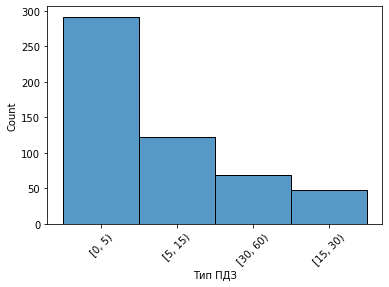

In [17]:
sns.histplot(df_2019, x='Тип ПДЗ');
plt.xticks(rotation=45);

In [18]:
    f_list=[                                                                            
   ', Нематериальные активы, RUB',                                      
   ', Основные средства , RUB',                                                              
   ', Внеоборотные активы, RUB',                                                     
   ', Дебиторская задолженность, RUB',                                     
   ', Оборотные активы, RUB',                                                                    
   ', Уставный капитал , RUB',                                                                 
   ', Капитал и резервы, RUB',                                               
   ', Заёмные средства (долгосрочные), RUB',                     
   ', Долгосрочные обязательства, RUB',                     
   ', Заёмные средства (краткосрочные), RUB',                 
   ', Кредиторская задолженность, RUB',                                     
   ', Краткосрочные обязательства, RUB',                                            
   ', Выручка, RUB',                                                                                 
   ', Себестоимость продаж, RUB',                      
   ', Прибыль (убыток) до налогообложения , RUB',            
   ', Прибыль (убыток) от продажи, RUB'             
    
  ]

In [19]:
order=["[0, 5)",     
"[5, 15)",      
'[15, 30)',      
'[30, 60)',     
'[60, 120)'     
]     

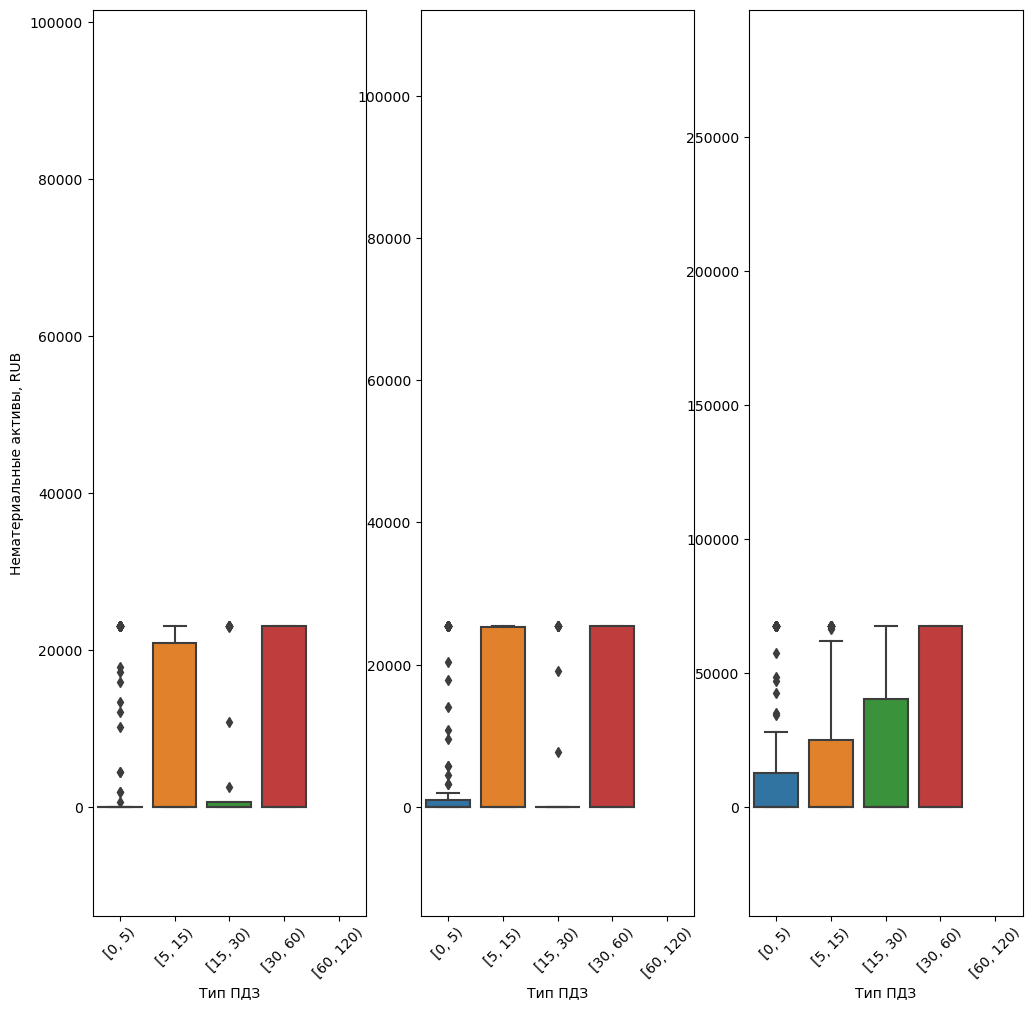

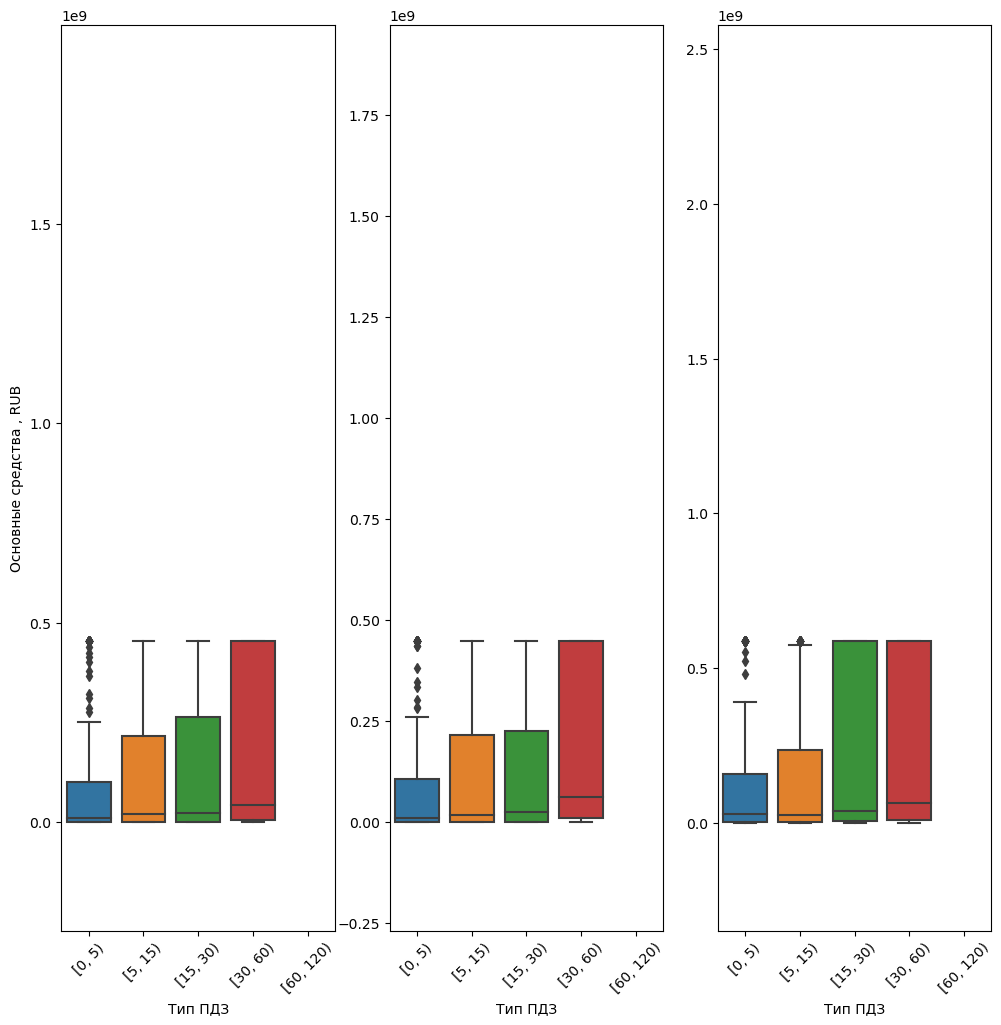

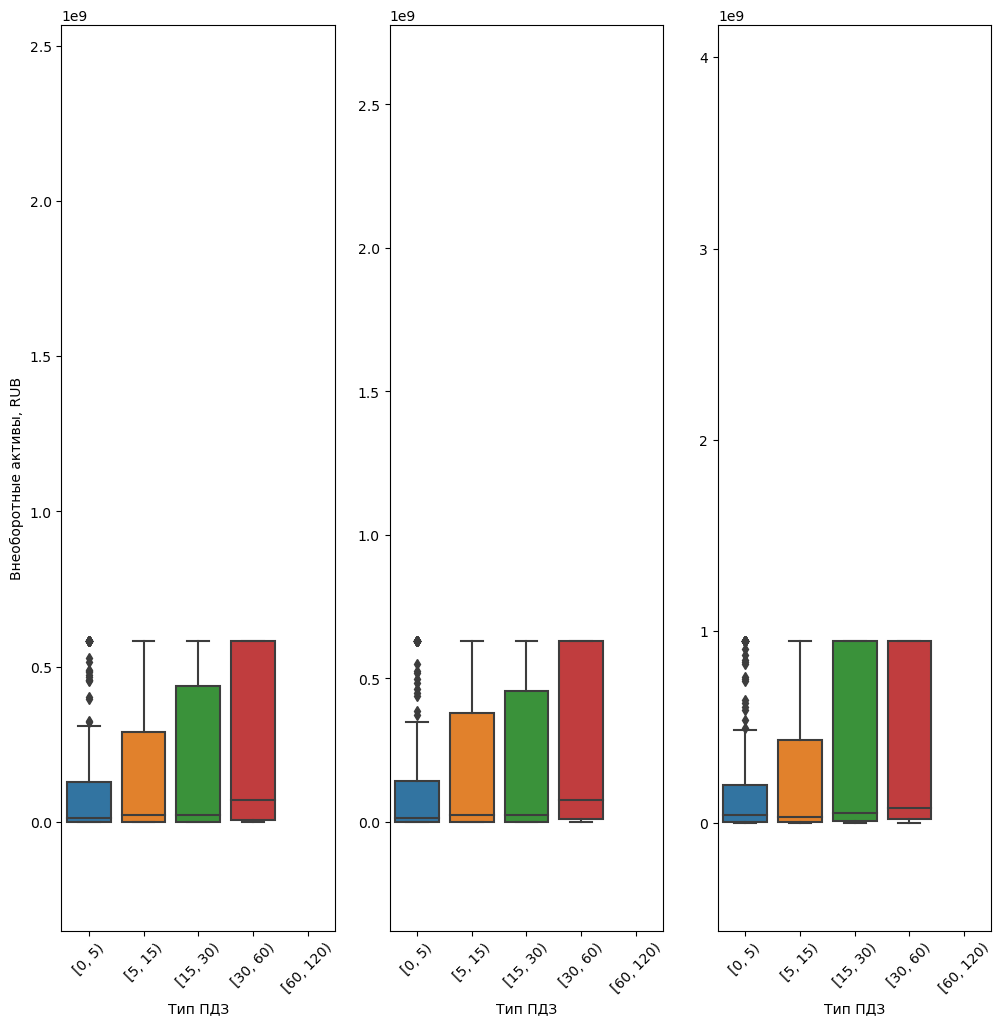

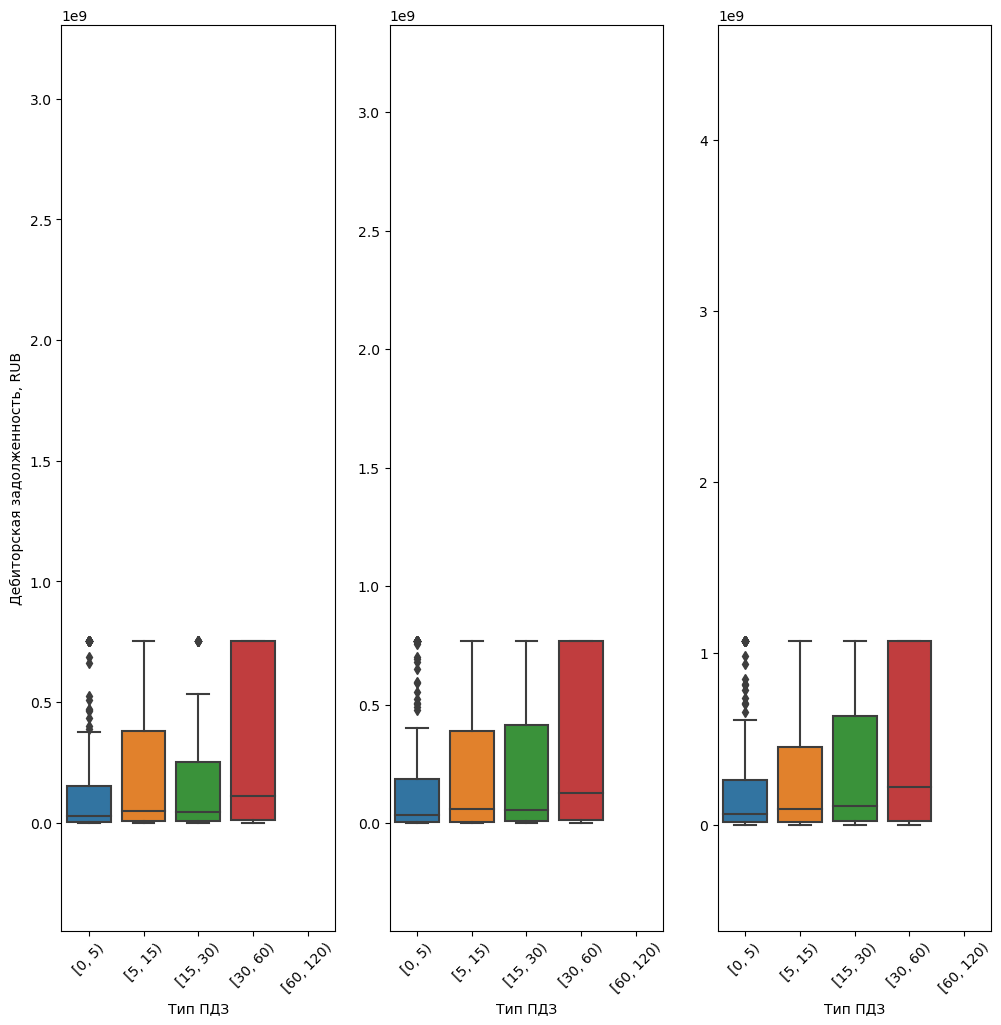

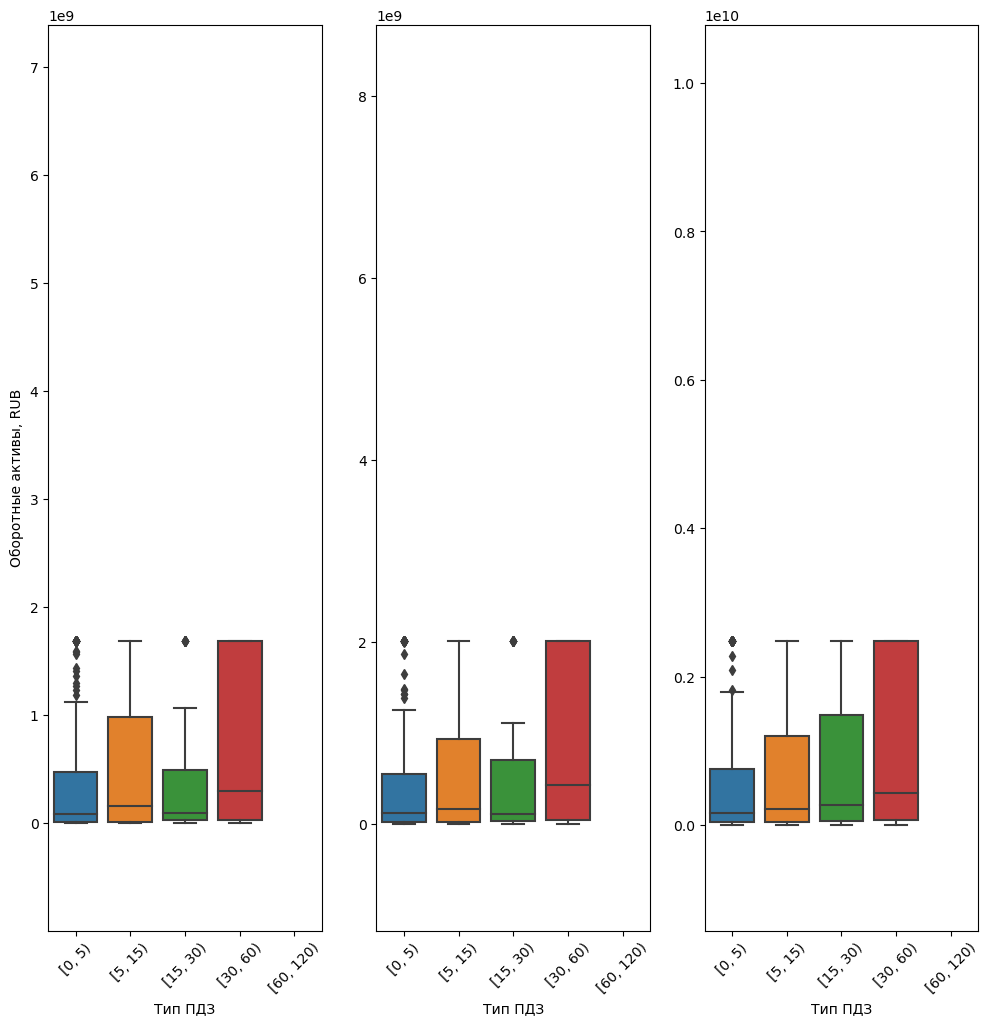

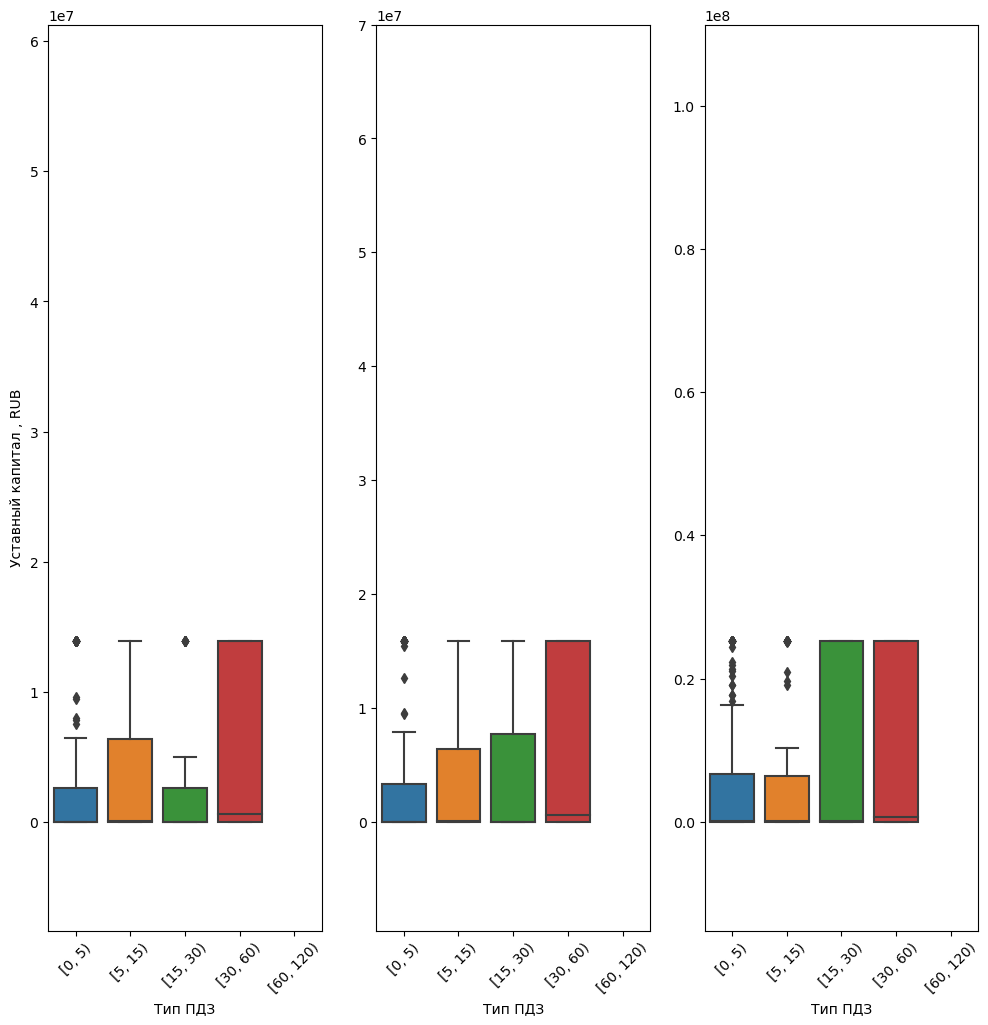

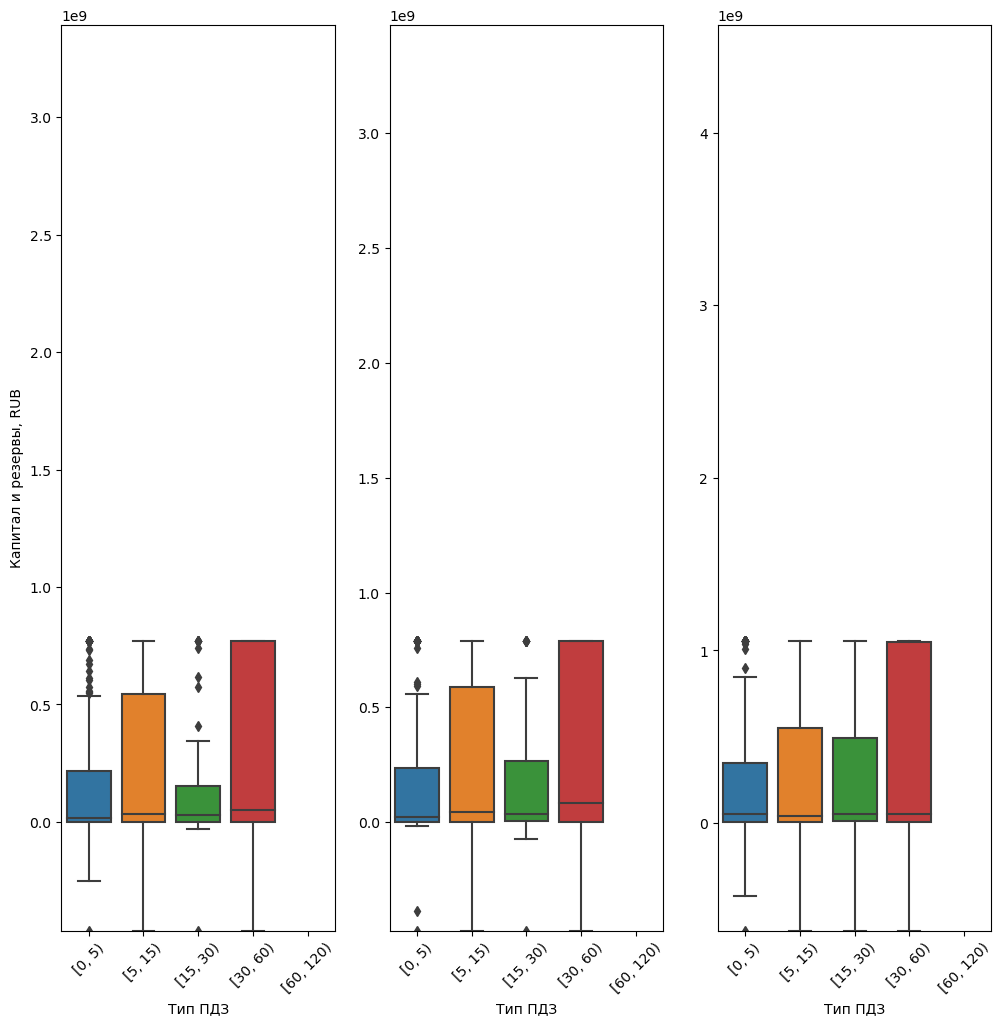

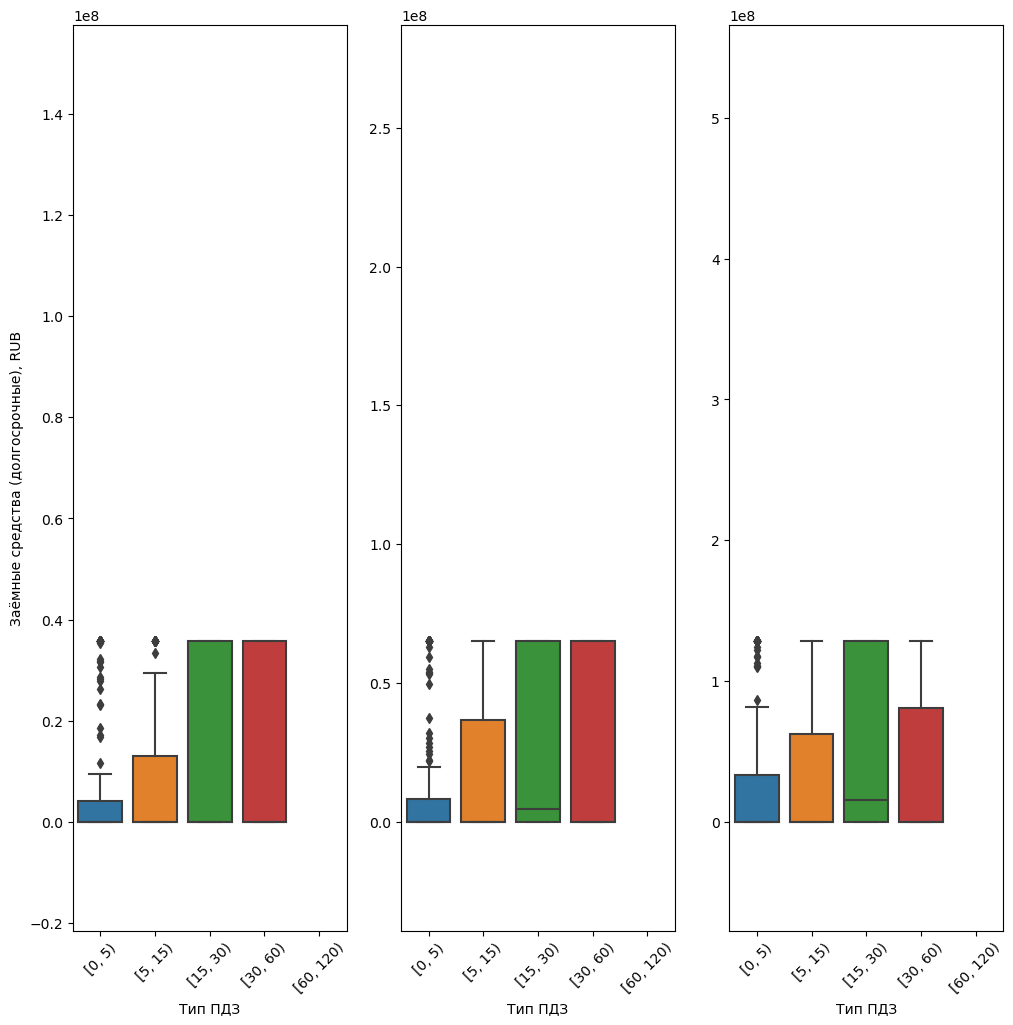

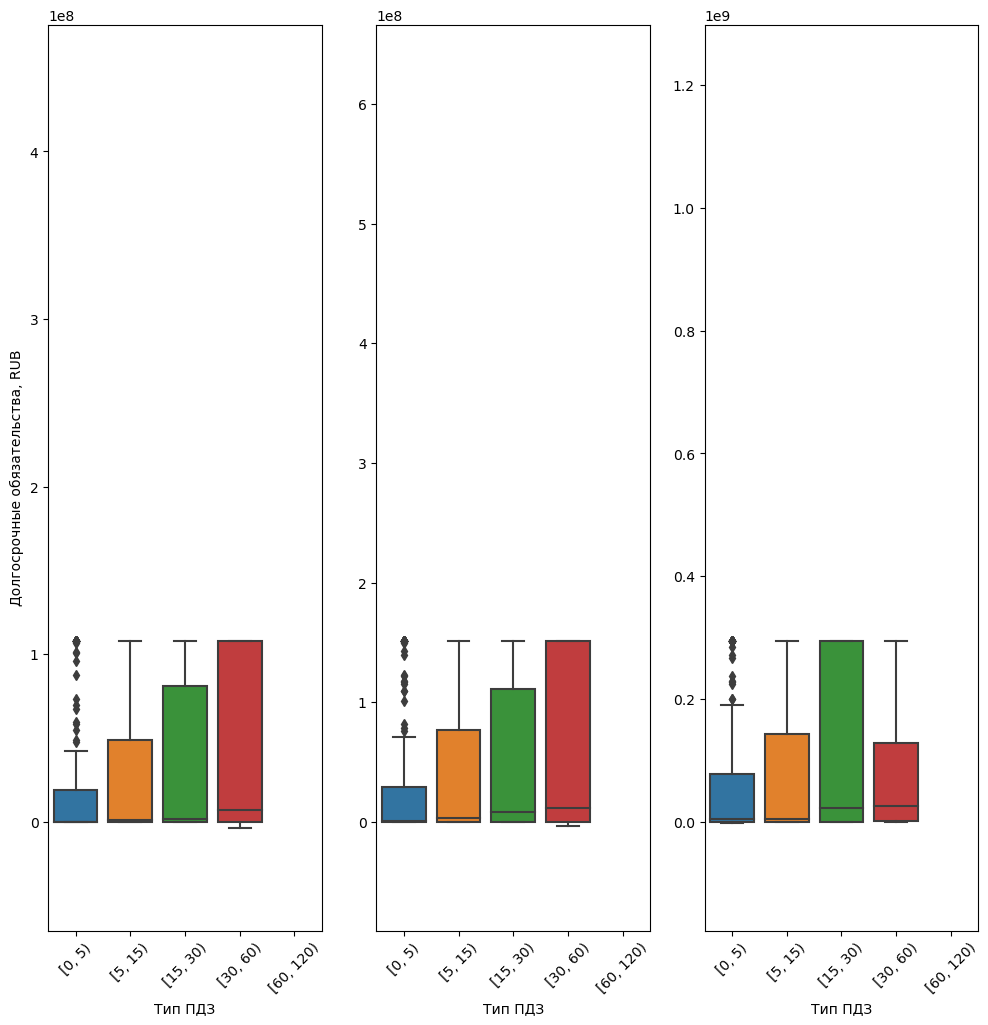

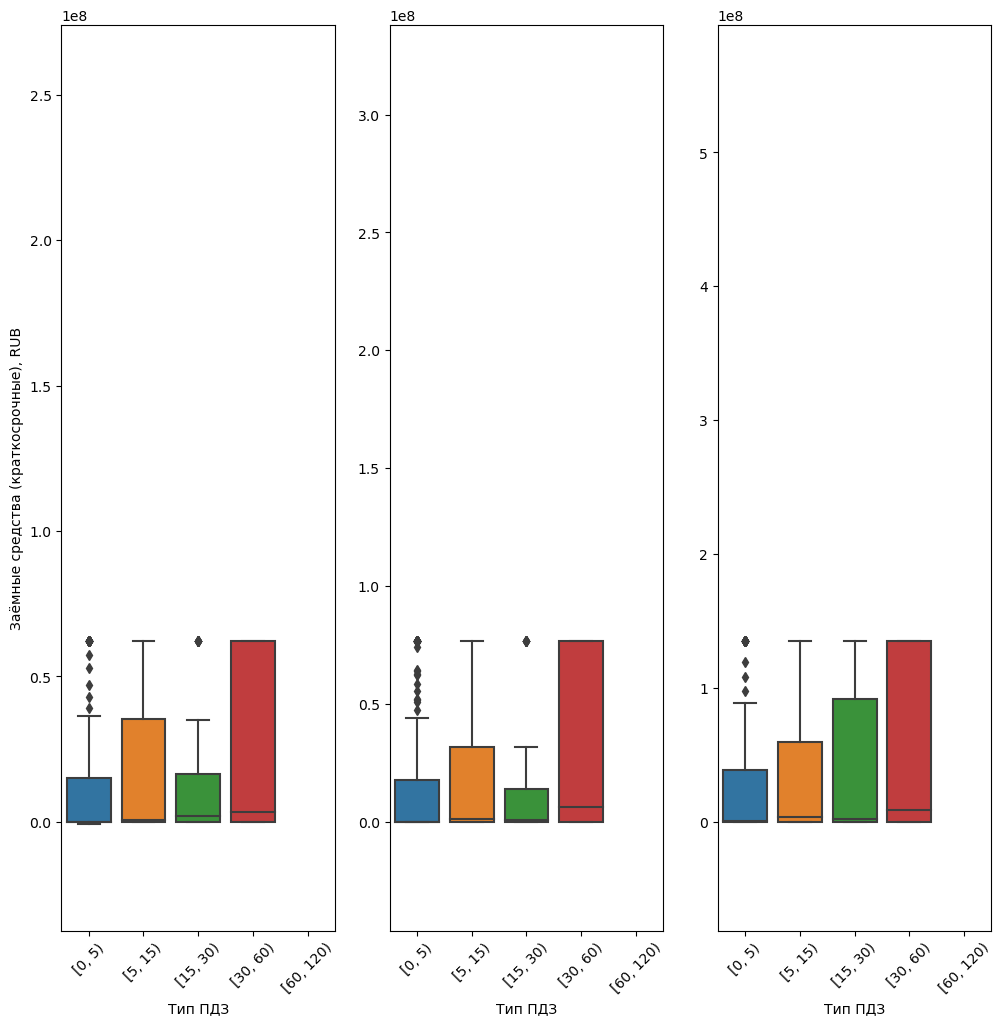

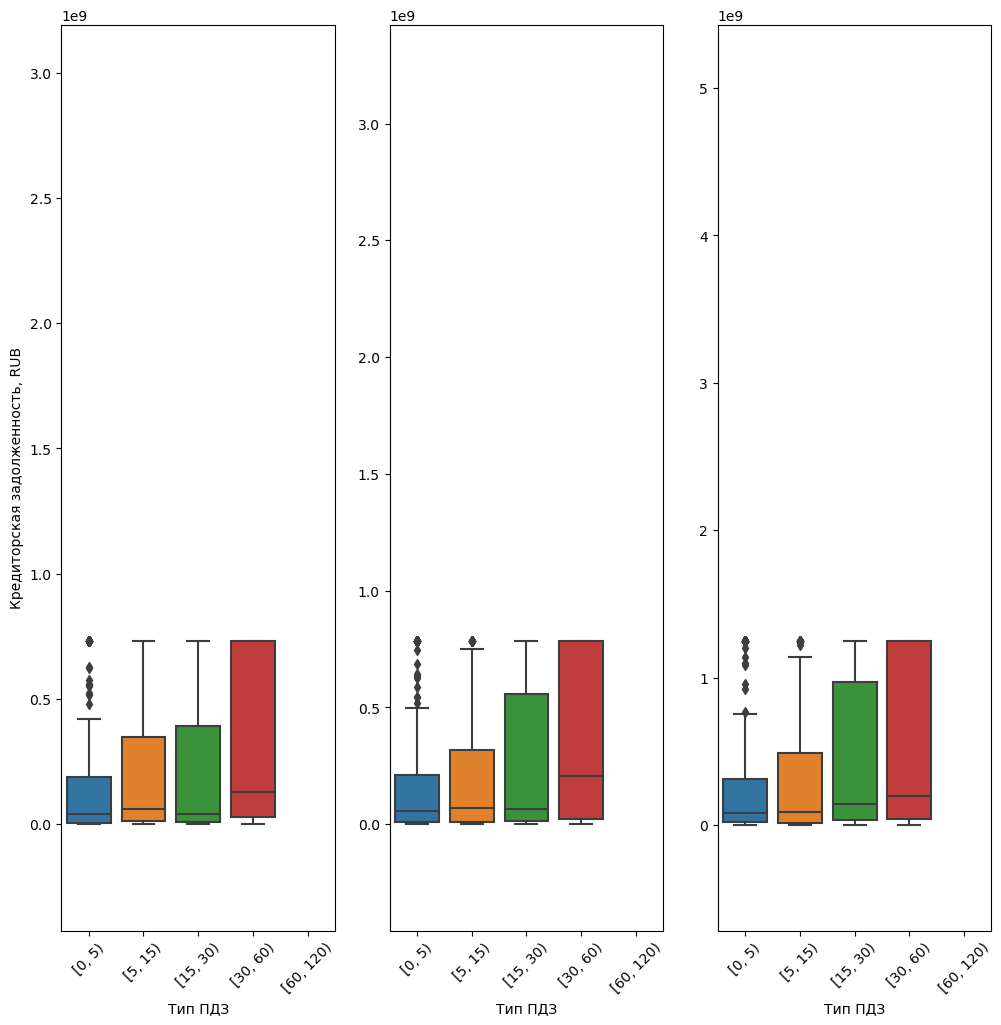

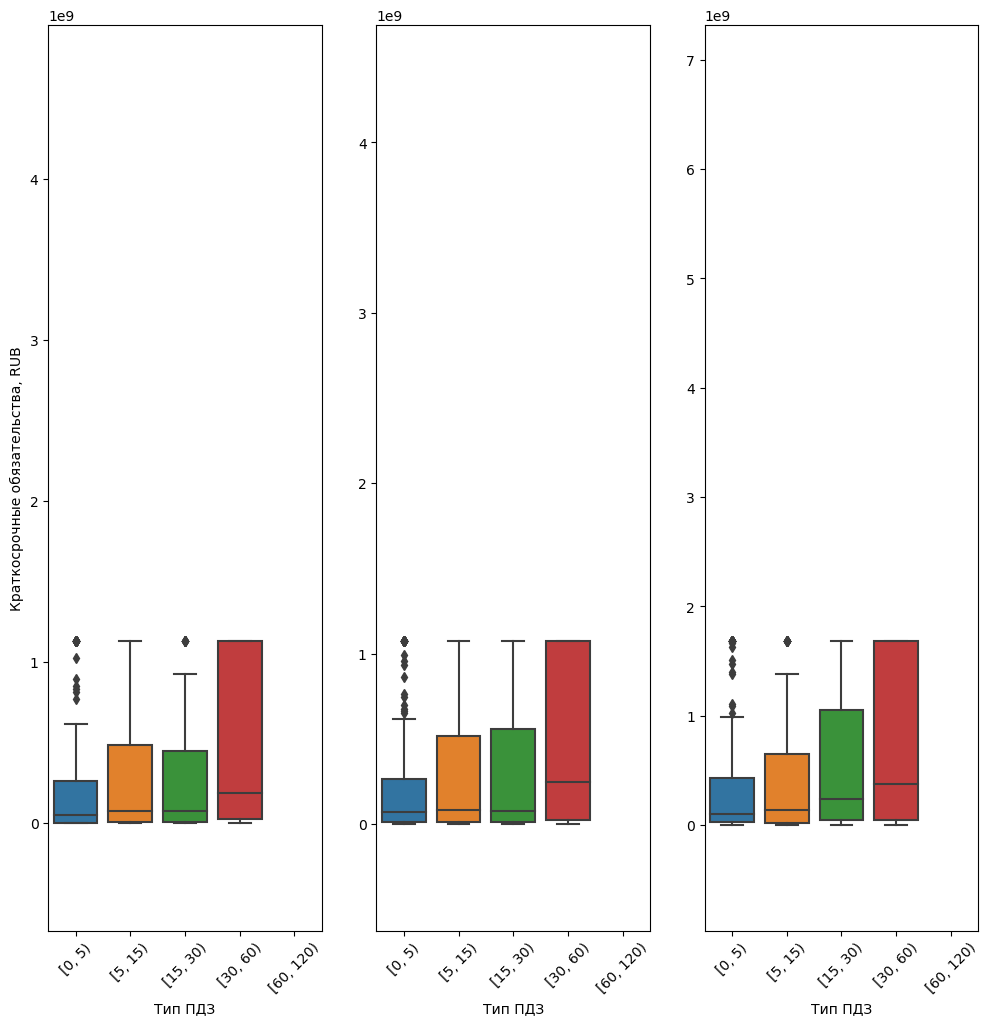

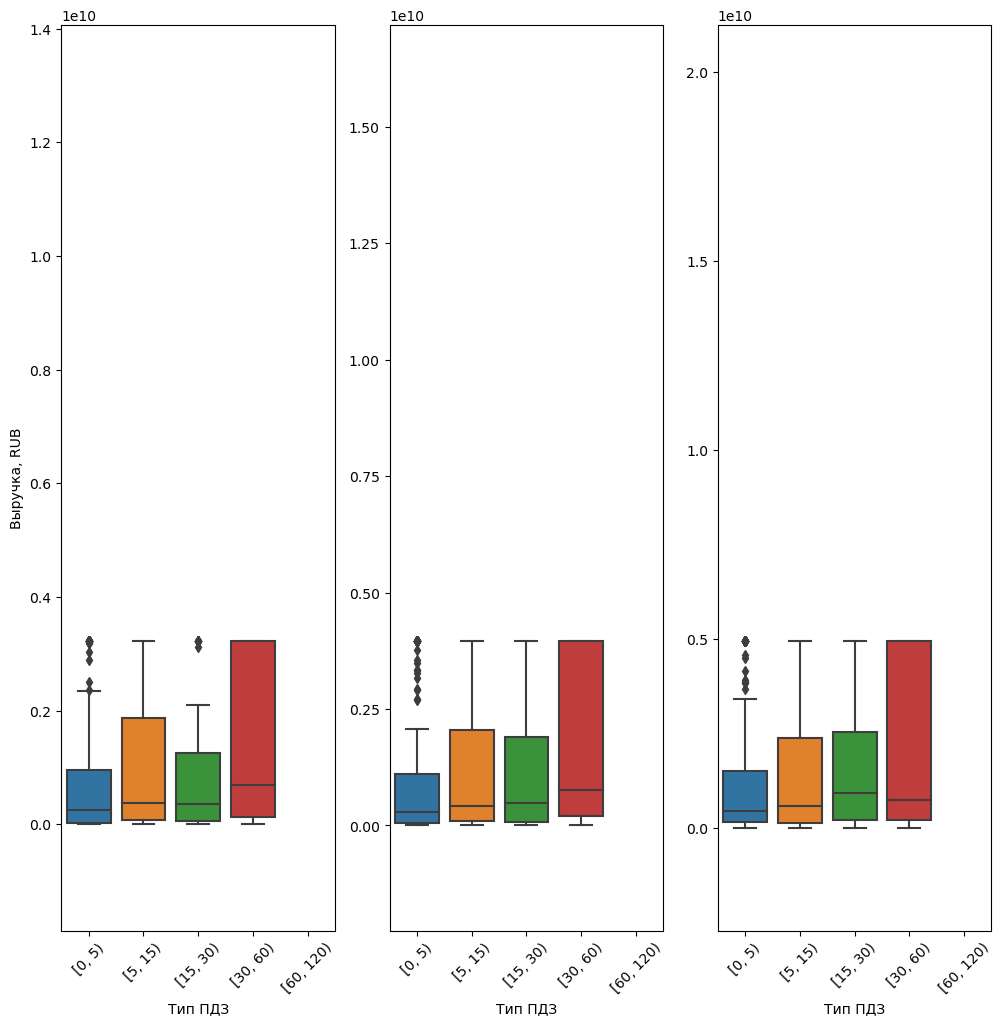

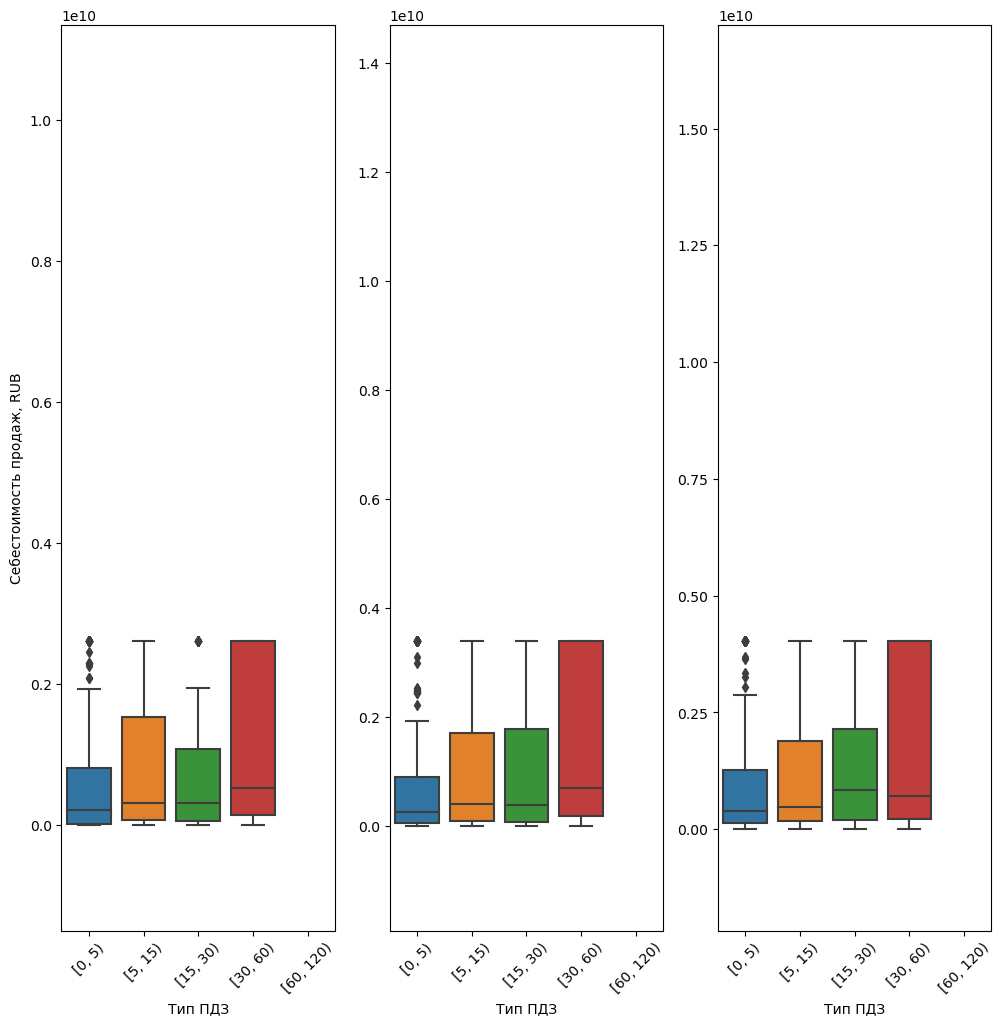

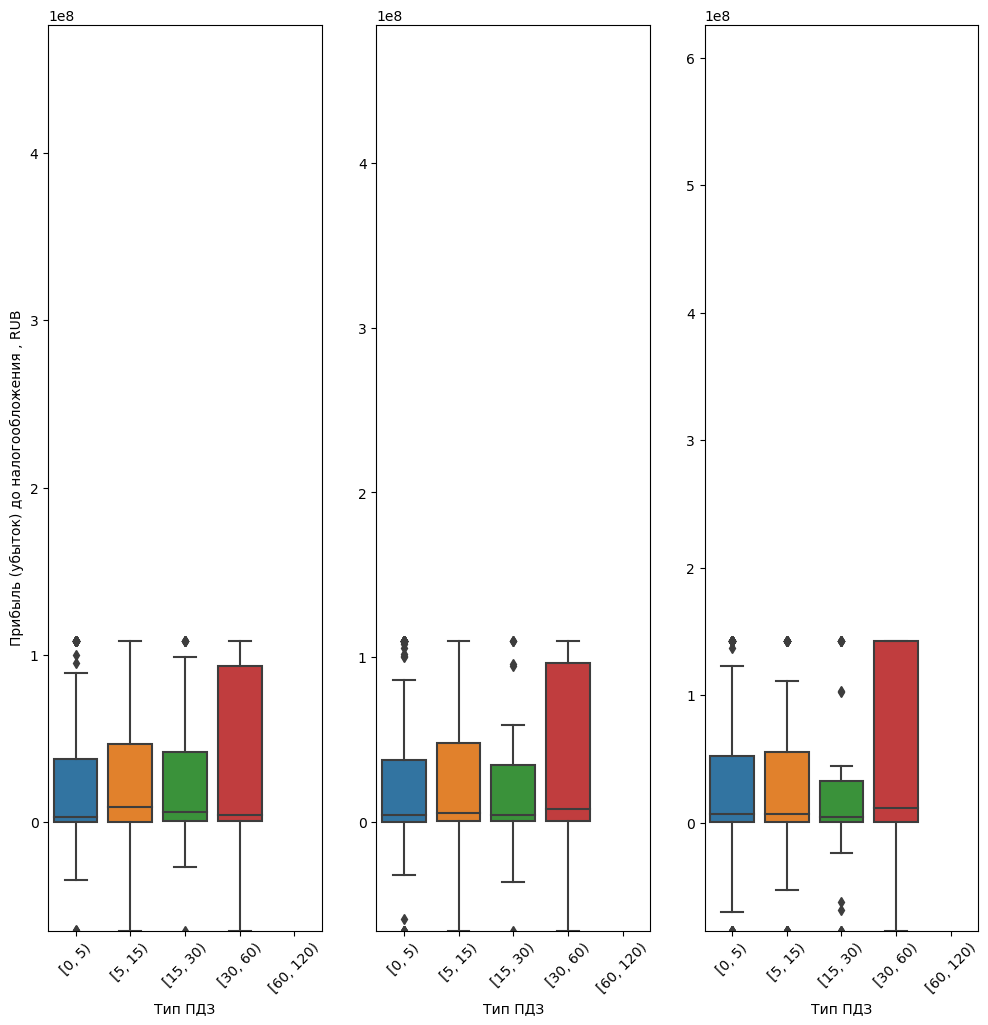

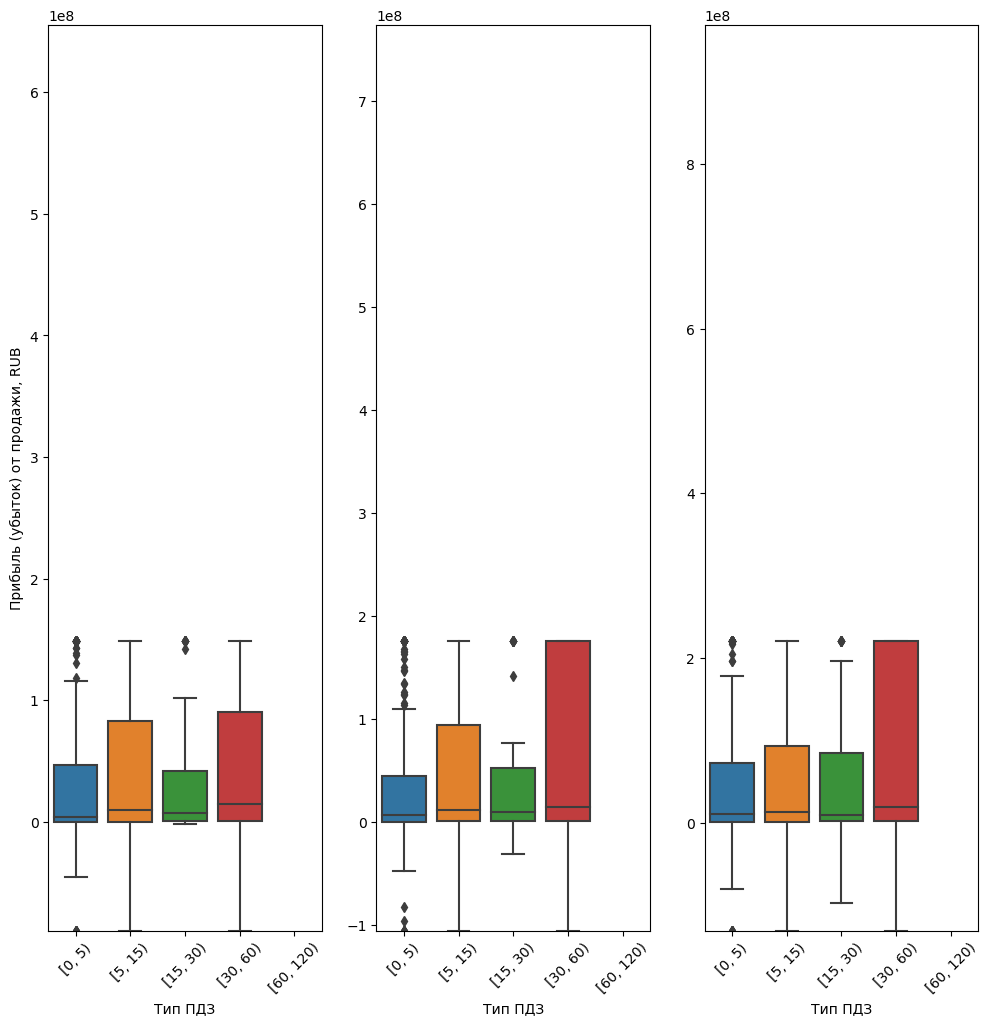

In [20]:
for f in f_list:
    fig = plt.figure(figsize=(12, 12), dpi=100)
    plt.subplot (1, 3, 1)
    f_name='2016'+f    
    ax=sns.boxplot(data=df_2019, x='Тип ПДЗ', y=df_2019[f_name],order=order).set(ylabel=f[2:])
    q_25=np.percentile(df_2019[f_name],25)
    q_75=np.percentile(df_2019[f_name],75)
    iqr=q_75-q_25
    min_y=q_25-1.5*iqr
    max_y=q_75+10*iqr
    plt.xticks(rotation=45);
    plt.ylim(min_y,max_y);
    
    plt.subplot (1, 3,2)
    f_name='2017'+f
    bx=sns.boxplot(data=df_2019, x='Тип ПДЗ', y=df_2019[f_name],order=order).set(ylabel=None)
    q_25=np.percentile(df_2019[f_name],25)
    q_75=np.percentile(df_2019[f_name],75)
    iqr=q_75-q_25
    min_y=q_25-1.5*iqr
    max_y=q_75+10*iqr    
    plt.xticks(rotation=45);
    plt.ylim(min_y,max_y);   
    
    plt.subplot (1, 3,3)
    f_name='2018'+f
    cx=sns.boxplot(data=df_2019, x='Тип ПДЗ', y=df_2019[f_name],order=order).set(ylabel=None)
    q_25=np.percentile(df_2019[f_name],25)
    q_75=np.percentile(df_2019[f_name],75)
    iqr=q_75-q_25
    min_y=q_25-1.5*iqr
    max_y=q_75+10*iqr    
    plt.xticks(rotation=45);
    plt.ylim(min_y,max_y);
    
 

Пока можно заметить, что чем больше финансовые показатели компании, тем выше срок задолженности. Попробуем классифицировать
компании по типам малый, средний и крупный бизнес:
https://ppt.ru/malie-predpriyatia

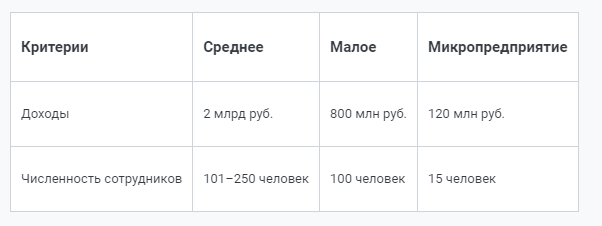

Возьмём за ориентир данные за 2018 год, как самый актуальный:

In [21]:
y='2018'
df_2019[y+'Доход_1, RUB']=(df_2019[y+', Капитал и резервы, RUB']+df_2019[y+', Себестоимость продаж, RUB']+df_2019[y+', Выручка, RUB']
                            +df_2019[y+', Прибыль (убыток) до налогообложения , RUB'])

In [22]:
df_2019['2018Доход_1, RUB'].describe()

count           531.000
mean     2926087858.205
std      3530735823.264
min      -430991719.745
25%       344773885.350
50%      1165480891.720
75%      4398917595.541
max     10196225477.707
Name: 2018Доход_1, RUB, dtype: float64

In [23]:
cut_labels = ['Отрицательный доход', 'Микро', 'Малый', 'Средний','Крупный']
cut_bins = [-10**12,0, 120*10**6, 8*10**8, 2*10**9,10**15]

df_2019['Тип_предприятия'] = pd.cut(df_2019['2018Доход_1, RUB'],
                       bins=cut_bins,
                       labels=cut_labels)

df_2019=df_2019.drop('2018Доход_1, RUB', axis=1)

In [24]:
df_2019['Тип_предприятия'].value_counts()

Крупный                202
Малый                  156
Средний                110
Микро                   38
Отрицательный доход     25
Name: Тип_предприятия, dtype: int64

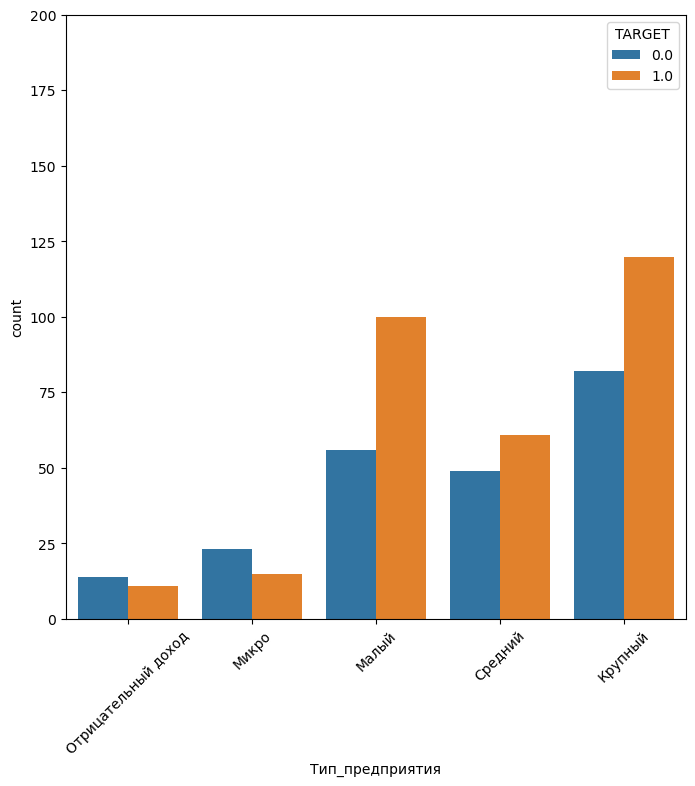

In [25]:
fig = plt.figure(figsize=(8, 8), dpi=100)
sns.countplot(x='Тип_предприятия', hue='TARGET', data=df_2019)
plt.xticks(rotation=45);
plt.ylim(0,2*10**2);

In [26]:
target_2=df_2019['Макс. ПДЗ за 2019 год, дней']

to_del=['Unnamed: 0',
        'Наименование ДП',
        'Макс. ПДЗ за 2019 год, дней',
         'Сред. ПДЗ за 2019 год, дней',
        'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',
        'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',
        'Кол-во раз ПДЗ за 2019 год, шт.']


df_2019=df_2019.drop(to_del, axis=1)

In [27]:
features=df_2019.drop(['TARGET','Тип ПДЗ'], axis=1)
target=df_2019['TARGET']


In [28]:
features_train, features_test, target_train, target_test=train_test_split(features, target, test_size=.2,random_state=RANDOM_STATE)
features_train, features_test, target2_train, target2_test=train_test_split(features, target_2, test_size=.2,random_state=RANDOM_STATE)

In [29]:
features_train=make_features_2019(features_train)
features_test=make_features_2019(features_test)

In [30]:
 clf_new = CatBoostClassifier(iterations = 1500,
                              loss_function = 'Logloss', eval_metric = 'F1',
                              random_seed=RANDOM_SEED,cat_features=['Тип_предприятия'],reg_lambda=1500,
                              early_stopping_rounds=450)


In [31]:
clf_new.fit(features_train, target_train, eval_set=(features_test, target_test),
                verbose = 500, use_best_model = True, plot = False)

0:	learn: 0.7386760	test: 0.6938776	best: 0.6938776 (0)	total: 189ms	remaining: 4m 43s
Stopped by overfitting detector  (450 iterations wait)

bestTest = 0.7810650888
bestIteration = 43

Shrink model to first 44 iterations.


In [32]:
res_new=pd.DataFrame(data=clf_new.get_feature_importance(), index=features_train.columns,columns=['FI']).sort_values(by='FI',ascending=False)
res_new.head(15)

FI
2018Выручка_vs_Обязательства, %              10.838
Оборачиваемость ПДЗ 16-17                     6.593
2018_Итого_Капитал_РЕЗЕРВЫ, руб.              5.141
DELTA_17-16_Выручка, RUB                      4.994
DELTA_18-17_Краткосрочные обязательства, RUB  3.822
2018Приход_Расход, %                          3.621
DELTA_18-17_Выручка, RUB                      3.163
2018Активы_Пассивы                            3.069
DELTA_17-16_Внеоборотные активы, RUB          2.886
DELTA_17-16_Капитал и резервы, RUB            2.761
DELTA_17-16_Основные средства , RUB           2.709
DELTA_18-17_Капитал и резервы, RUB            2.476
DELTA_17-16_Оборотные активы, RUB             2.420
2018К-т Альтмана                              2.413
2018Рентабельность,%                          2.374

In [33]:
features_current=make_features_2019(features)

In [34]:
features_current['Задолженность']=target

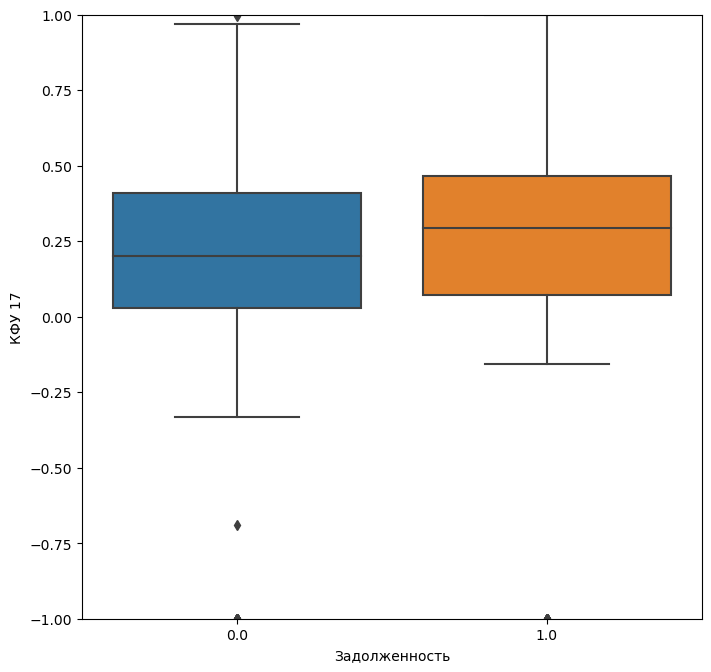

In [35]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_current['КФУ 17'], x=features_current['Задолженность'])
p.set(ylim=(-1, 1));

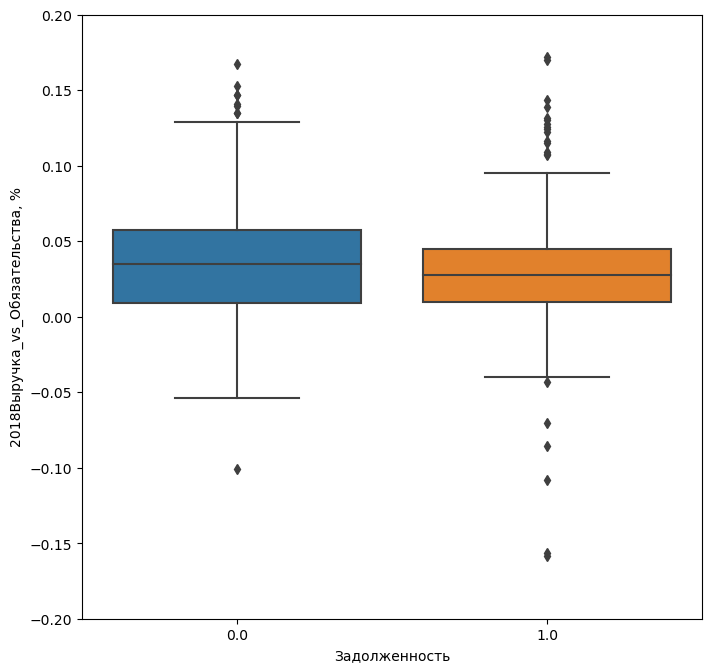

In [36]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_current['2018Выручка_vs_Обязательства, %'], x=features_current['Задолженность'])
p.set(ylim=(-0.2, 0.2));

Попробуем обучить модель для предсказания срока задолженности

In [37]:
to_use=res_new[res_new['FI']>0].index

features_train=features_train[to_use]
features_test=features_test[to_use]

In [38]:
 clf_new_reg = CatBoostRegressor(iterations = 1500,loss_function = 'RMSE',
                              random_seed=RANDOM_SEED,reg_lambda=5,cat_features=['Тип_предприятия'],
                             custom_metric="R2",
                              early_stopping_rounds=450)

In [39]:
clf_new_reg.fit(features_train, target2_train, eval_set=(features_test, target2_test),
                verbose = 500, use_best_model = True, plot = False)

0:	learn: 11.0594044	test: 11.4035181	best: 11.4035181 (0)	total: 56.1ms	remaining: 1m 24s
500:	learn: 5.3939140	test: 11.1875156	best: 11.0647956 (79)	total: 22.2s	remaining: 44.3s
Stopped by overfitting detector  (450 iterations wait)

bestTest = 11.06479558
bestIteration = 79

Shrink model to first 80 iterations.


In [40]:
r2 = eval_metric(target2_train,clf_new_reg.predict(features_train) , 'R2')

In [41]:
r2

[0.2846027398975992]

Пока удалось получить модель с ошибкой в 10 дней в предсказании и низкой способностью объяснить дисперсию в данных.

In [42]:
df_2019_outliers

Unnamed: 0  Наименование ДП  Макс. ПДЗ за 2019 год, дней  \
9             9                9                          124   
10           10               10                           77   
12           12               12                           88   
28           28               28                          747   
44           44               44                          126   
57           57               57                          560   
60           60               60                           91   
65           65               65                          227   
66           66               66                          153   
84           84               84                          842   
106         106              106                          101   
118         118              118                           65   
126         126              126                          820   
155         155              155                          608   
172         172              172                           69   
173         173              173                          786   
203         203              203                          115   
204         204              204                           66   
205         205              205                           63   
247         247              247                          116   
253         253              253                          114   
260         260              260                          835   
262         262              262                          124   
284         284              284                          854   
310         310              310                          884   
361         361              361                           77   
364         364              364                          625   
422         422              422                           61   
470         470              470                          565   
477         477              477                          328   
488         488              488                          670   

     Сред. ПДЗ за 2019 год, дней  \
9                         16.315   
10                        17.929   
12                         8.118   
28                       113.700   
44                       108.800   
57                        75.207   
60                        91.000   
65                       145.500   
66                       122.286   
84                        20.842   
106                       13.370   
118                       32.667   
126                      148.230   
155                      608.000   
172                       11.671   
173                       58.357   
203                       78.000   
204                        5.752   
205                       19.403   
247                       37.750   
253                       10.955   
260                      121.853   
262                       31.235   
284                      112.469   
310                       27.800   
361                       68.000   
364                       24.750   
422                       17.423   
470                      123.400   
477                       62.333   
488                       68.880   

     Кол-во просрочек свыше 5-ти дней за 2019 год, шт.  \
9                                                   34   
10                                                  55   
12                                                  14   
28                                                  25   
44                                                   5   
57                                                 133   
60                                                   1   
65                                                   2   
66                                                  14   
84                                                  23   
106                                                 20   
118                                                  6   
126              

In [43]:
df_2019_outliers.describe().T

count            mean  \
Unnamed: 0                                        31.000         196.613   
Наименование ДП                                   31.000         196.613   
Макс. ПДЗ за 2019 год, дней                       31.000         354.226   
Сред. ПДЗ за 2019 год, дней                       31.000          77.484   
Кол-во просрочек свыше 5-ти дней за 2019 год, шт. 31.000          32.742   
Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб. 31.000    28495789.563   
Кол-во раз ПДЗ за 2019 год, шт.                   31.000          51.258   
2016, Нематериальные активы, RUB                  31.000   235173351.140   
2017, Нематериальные активы, RUB                  31.000   349091945.757   
2018, Нематериальные активы, RUB                  31.000   315763262.790   
2016, Основные средства , RUB                     31.000 15191690117.115   
2017, Основные средства , RUB                     31.000 16881240579.412   
2018, Основные средства , RUB                     31.000 18475356667.352   
2016, Внеоборотные активы, RUB                    31.000 30432129504.828   
2017, Внеоборотные активы, RUB                    31.000 31962782186.152   
2018, Внеоборотные активы, RUB                    31.000 35172041380.727   
2016, Дебиторская задолженность, RUB              31.000  8165691986.850   
2017, Дебиторская задолженность, RUB              31.000  8735106143.415   
2018, Дебиторская задолженность, RUB              31.000  8708952640.230   
2016, Оборотные активы, RUB                       31.000 23601606615.985   
2017, Оборотные активы, RUB                       31.000 22380036696.117   
2018, Оборотные активы, RUB                       31.000 22126394123.690   
2016, Уставный капитал , RUB                      31.000   800155044.175   
2017, Уставный капитал , RUB                      31.000   828719745.223   
2018, Уставный капитал , RUB                      31.000   520437826.176   
2016, Капитал и резервы, RUB                      31.000 15554225436.614   
2017, Капитал и резервы, RUB                      31.000 17848525066.776   
2018, Капитал и резервы, RUB                      31.000 17297677172.796   
2016, Заёмные средства (долгосрочные), RUB        31.000 16987241812.205   
2017, Заёмные средства (долгосрочные), RUB        31.000 16805083254.572   
2018, Заёмные средства (долгосрочные), RUB        31.000 19833029587.015   
2016, Долгосрочные обязательства, RUB             31.000 22512241483.460   
2017, Долгосрочные обязательства, RUB             31.000 22231779453.462   
2018, Долгосрочные обязательства, RUB             31.000 24937063262.790   
2016, Заёмные средства (краткосрочные), RUB       31.000  5796810622.560   
2017, Заёмные средства (краткосрочные), RUB       31.000  5224725539.347   
2018, Заёмные средства (краткосрочные), RUB       31.000  4701100575.303   
2016, Кредиторская задолженность, RUB             31.000  9305094472.981   
2017, Кредиторская задолженность, RUB             31.000  8284862810.766   
2018, Кредиторская задолженность, RUB             31.000  9579064084.652   
2016, Краткосрочные обязательства, RUB            31.000 15967269180.193   
2017, Краткосрочные обязательства, RUB            31.000 14262514362.030   
2018, Краткосрочные обязательства, RUB            31.000 15063695027.738   
2016, Выручка, RUB                                31.000 27400121080.748   
2017, Выручка, RUB                                31.000 31813459358.948   
2018, Выручка, RUB                                31.000 39946720053.421   
2016, Себестоимость продаж, RUB                   31.000 17487559400.041   
2017, Себестоимость продаж, RUB                   31.000 20667581199.918   
2018, Себестоимость продаж, RUB                   31.000 23650169015.821   
2016, Прибыль (убыток) до налогообложения , RUB   31.000  6715671871.790   
2017, Прибыль (убыток) до налогообложения , RUB   31.000  9440580110.951   
2018, Прибыль (убыток) до налогообложения , RUB   31.000 11868691945.757   
2016, Прибыль (убыток) 

In [44]:
df_2019_outliers['Тип ПДЗ'] = pd.cut(df_2019_outliers['Макс. ПДЗ за 2019 год, дней'],bins=[0,60,120,180,240,360,9999],right=False).astype(str)

In [45]:
df_2019_outliers['Тип ПДЗ'].value_counts()

[60, 120)      13
[360, 9999)    12
[120, 180)      4
[240, 360)      1
[180, 240)      1
Name: Тип ПДЗ, dtype: int64

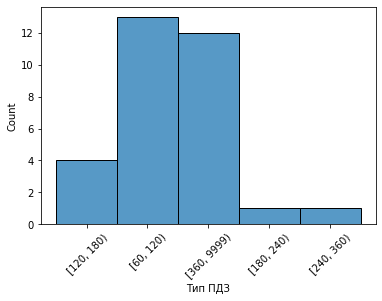

In [46]:
sns.histplot(df_2019_outliers, x='Тип ПДЗ');
plt.xticks(rotation=45);

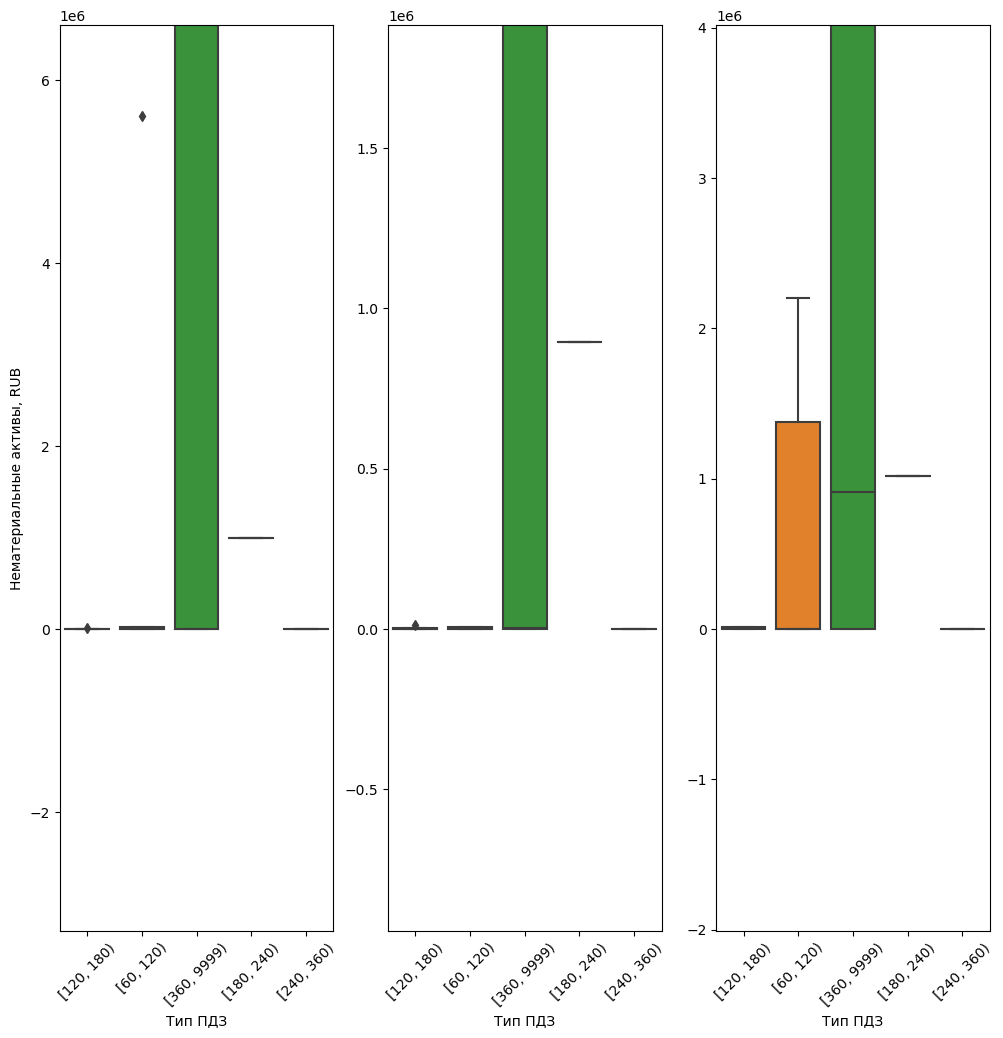

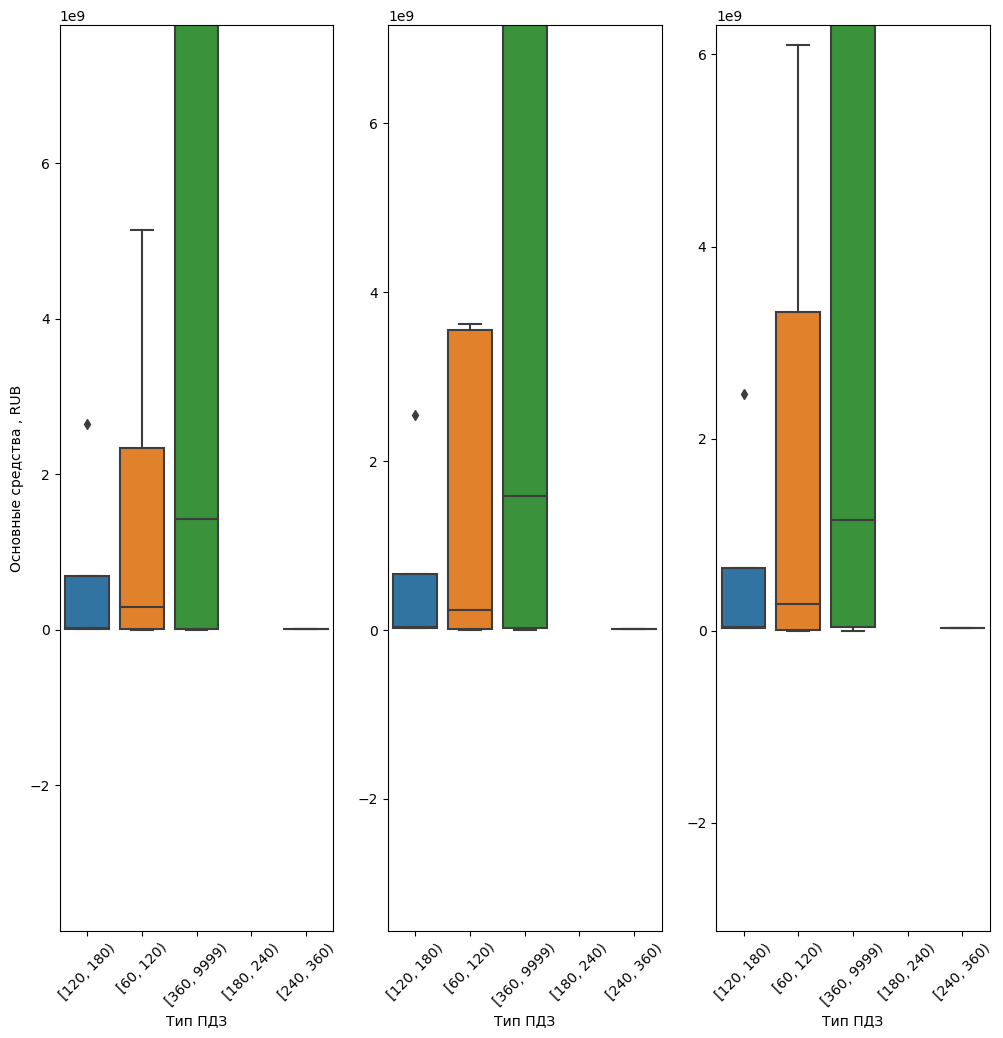

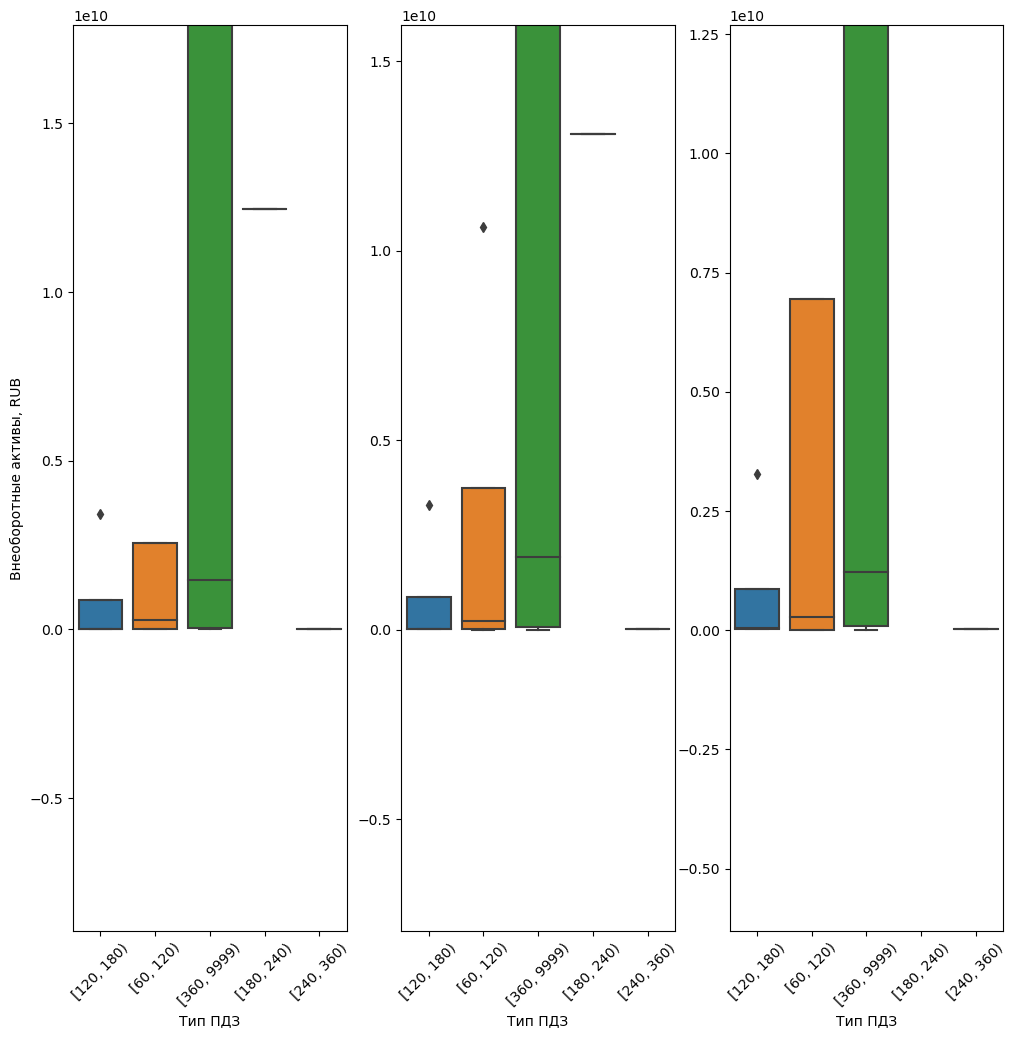

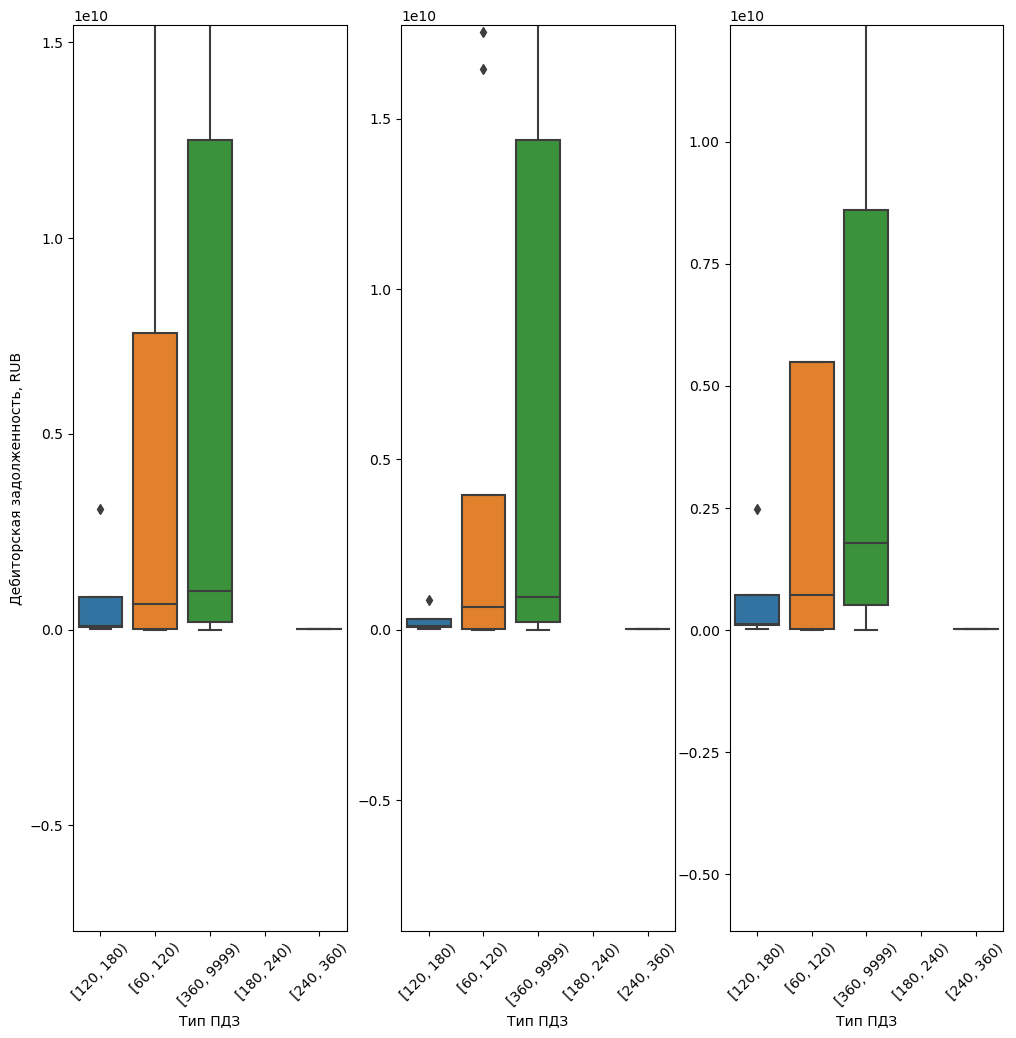

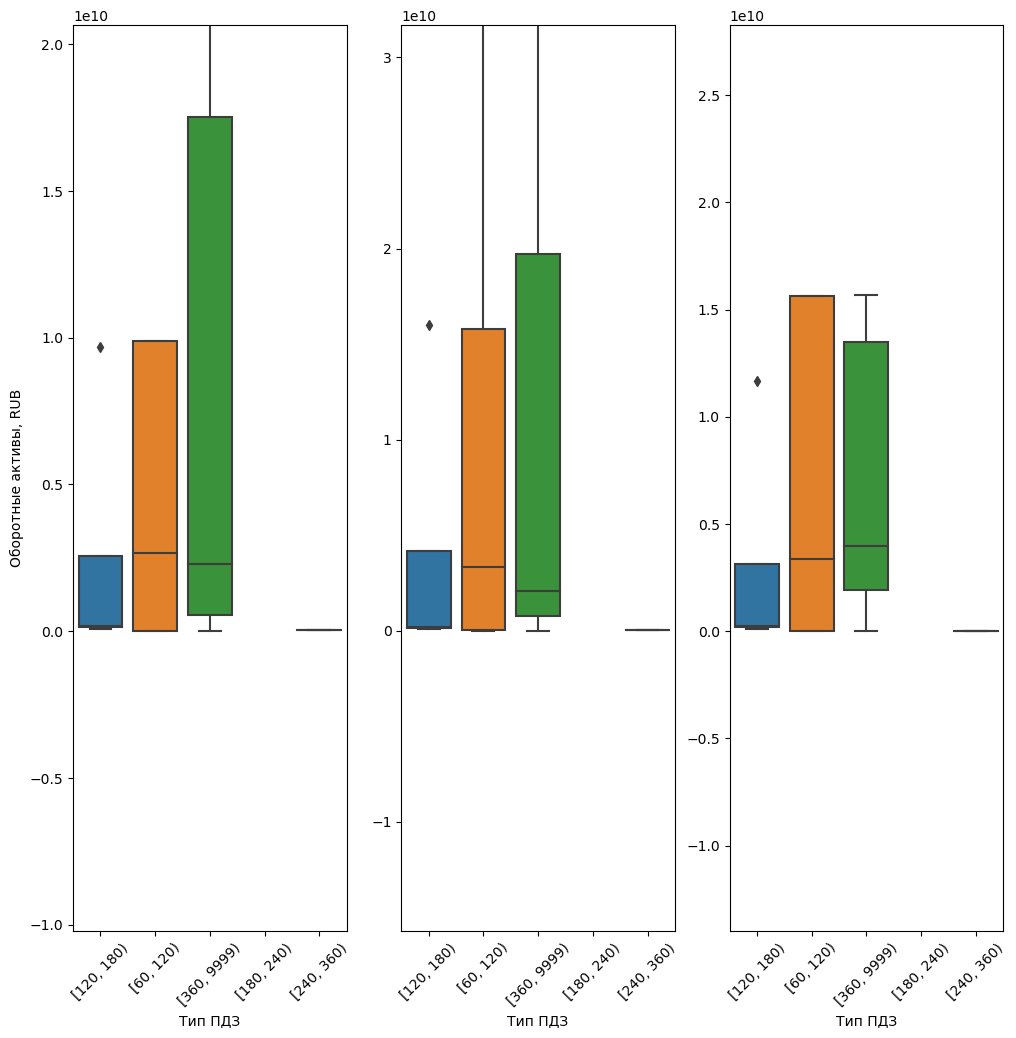

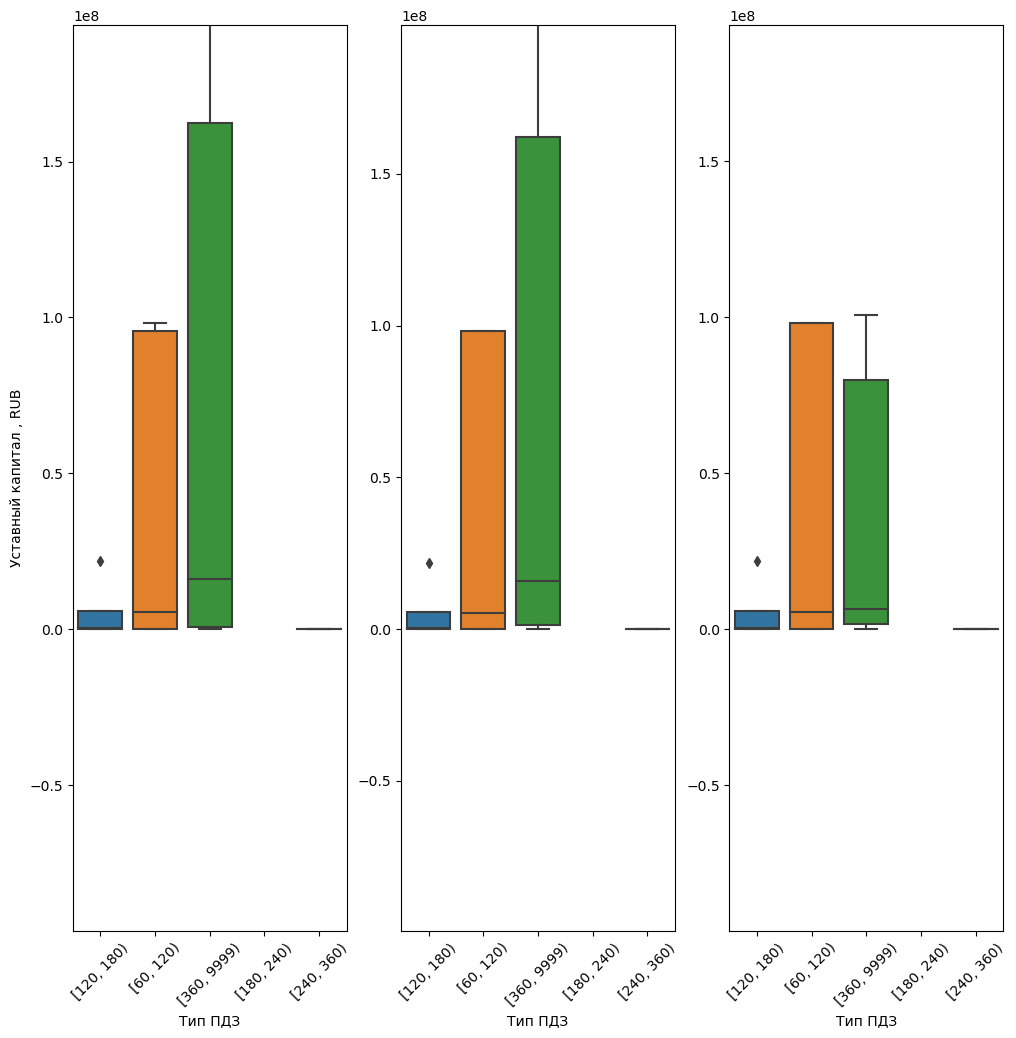

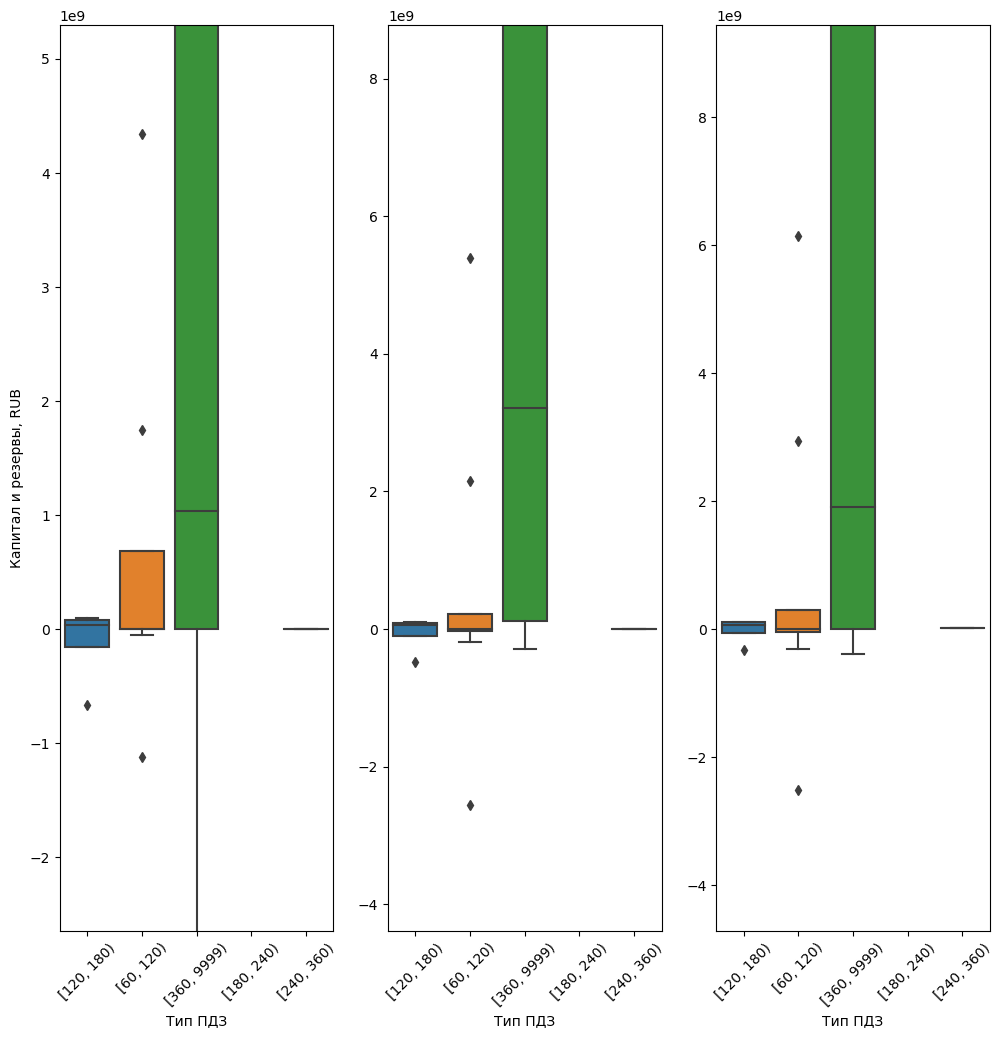

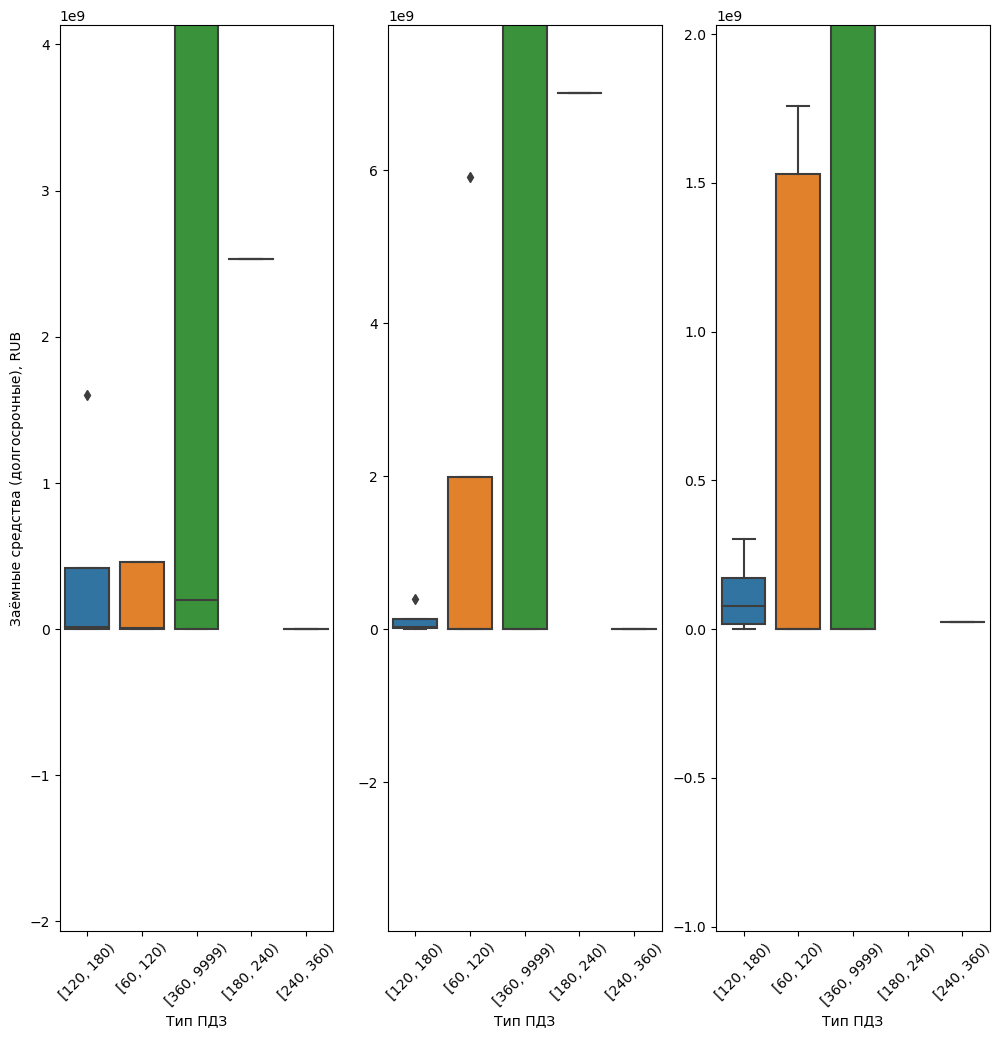

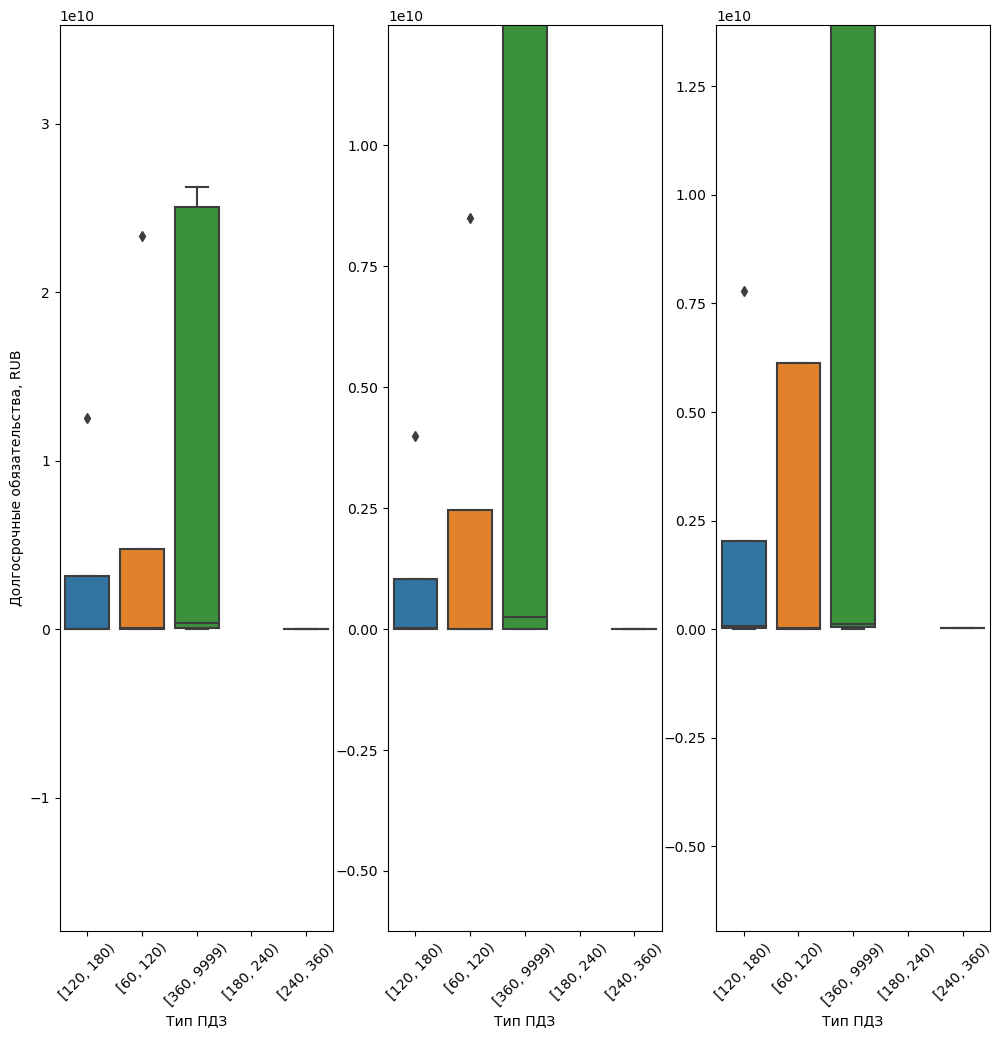

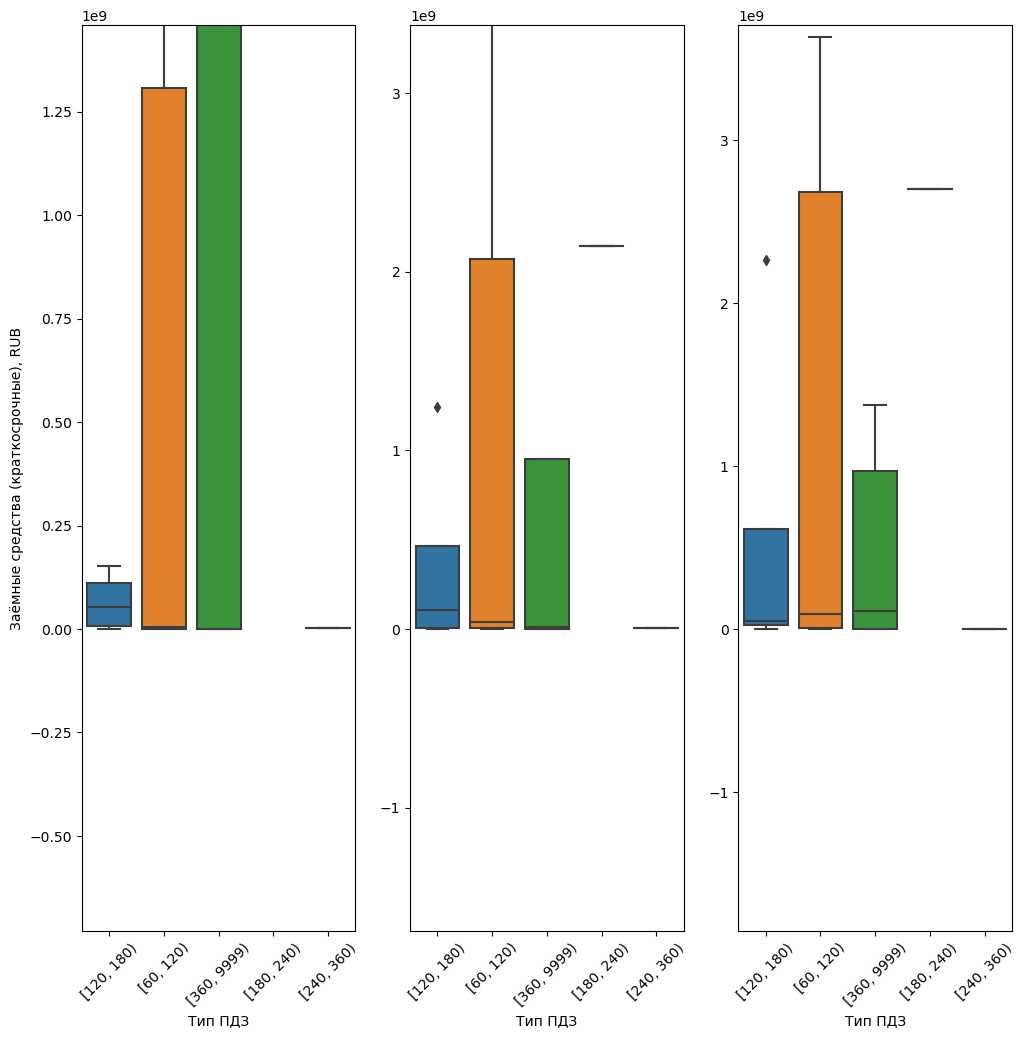

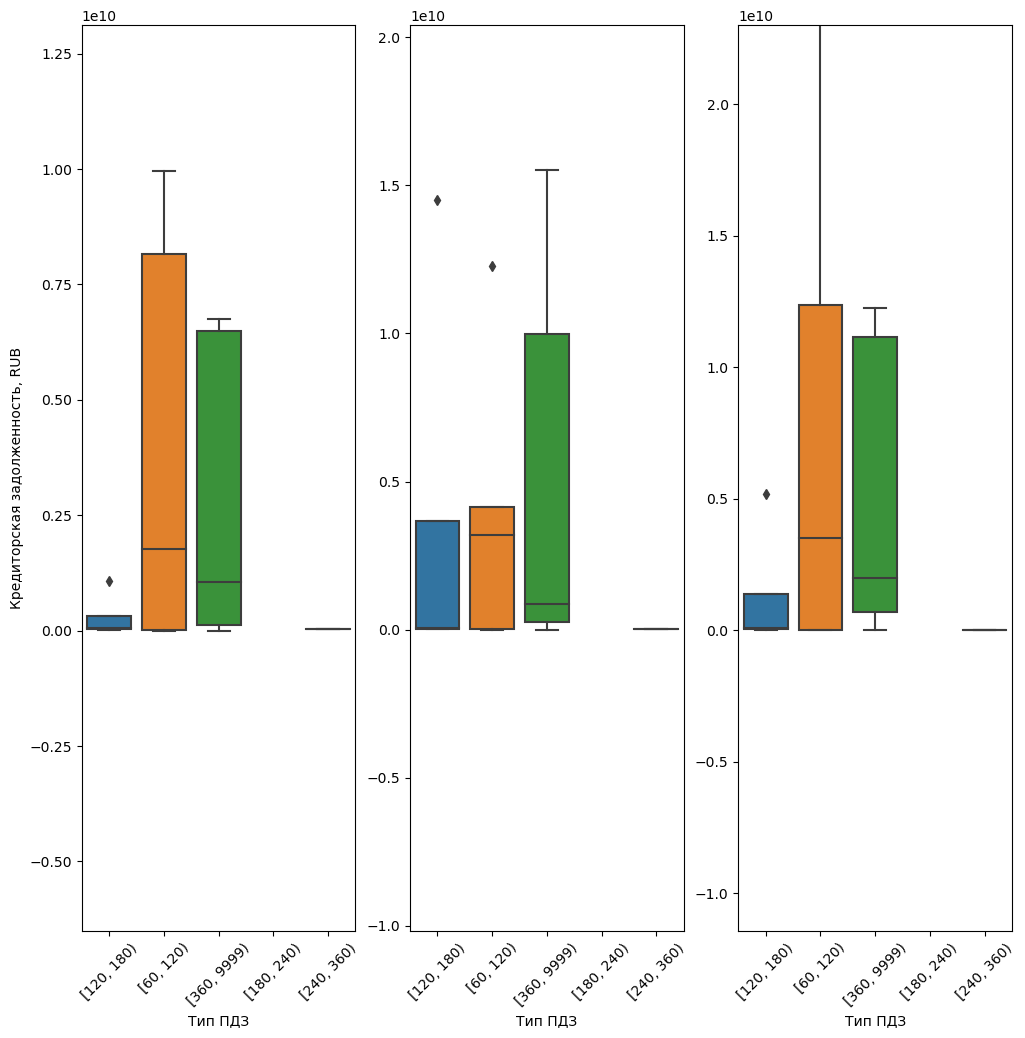

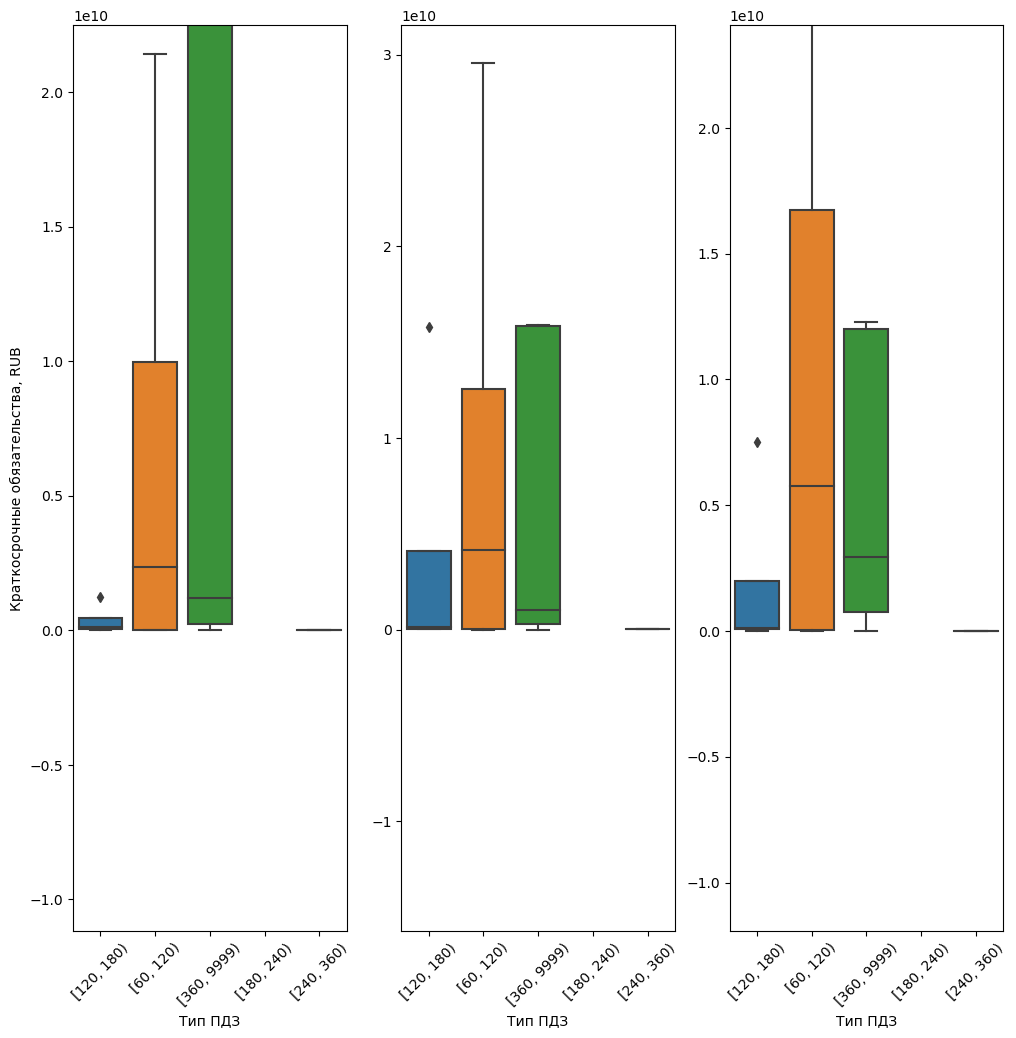

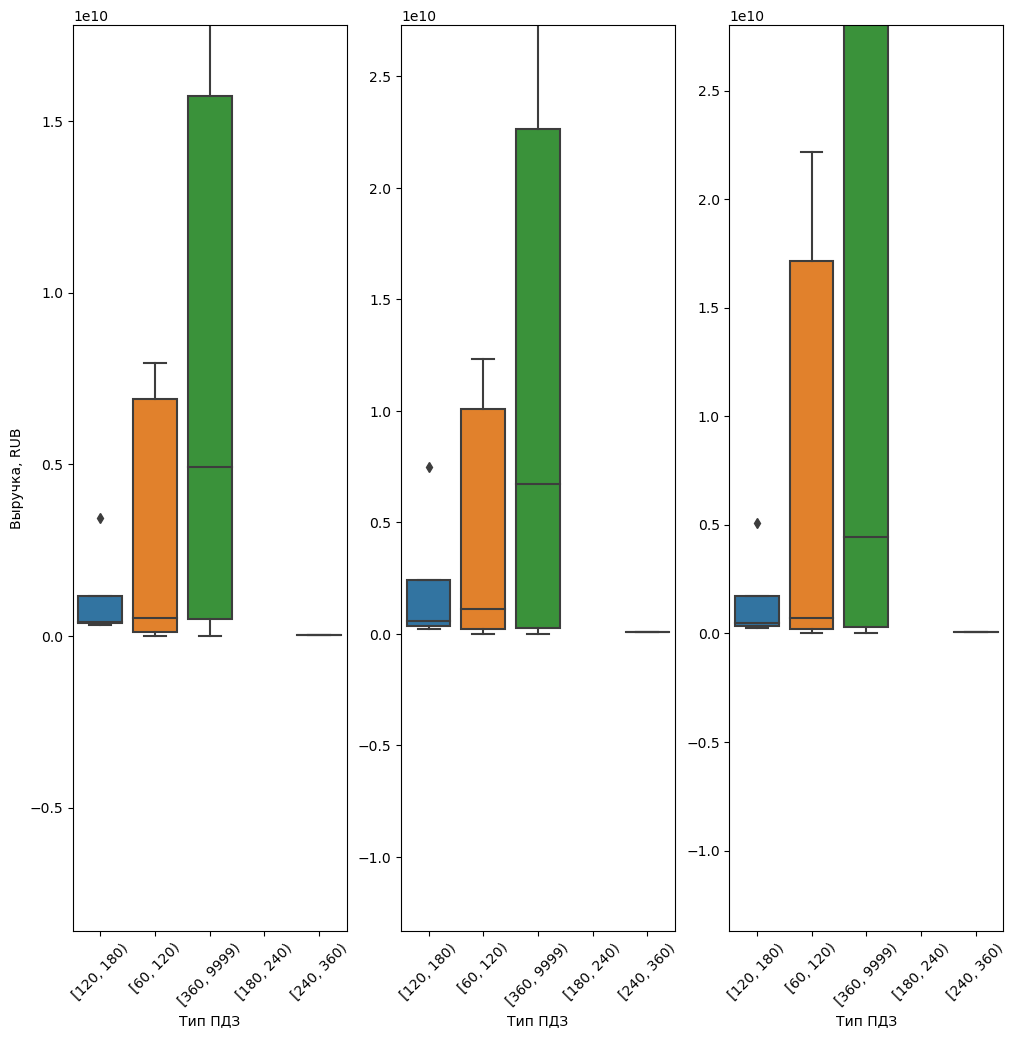

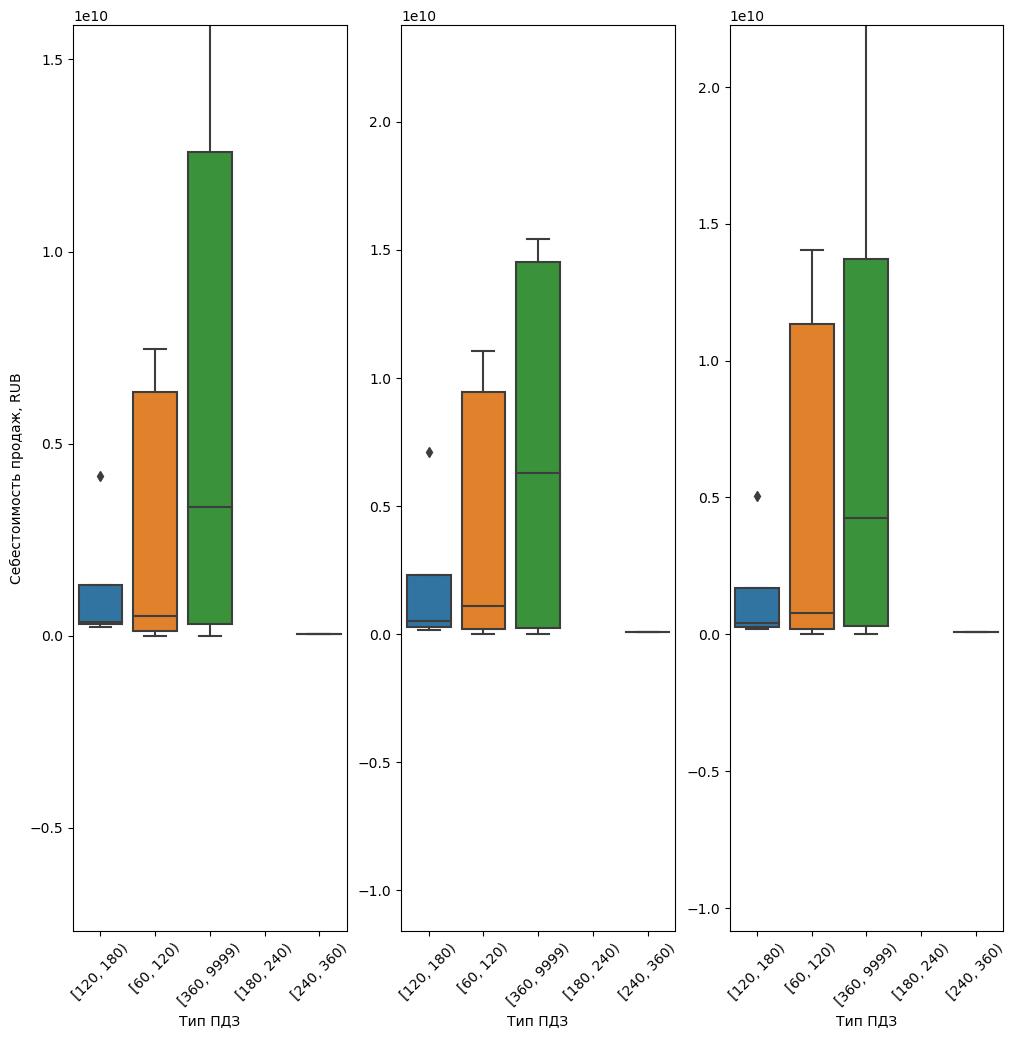

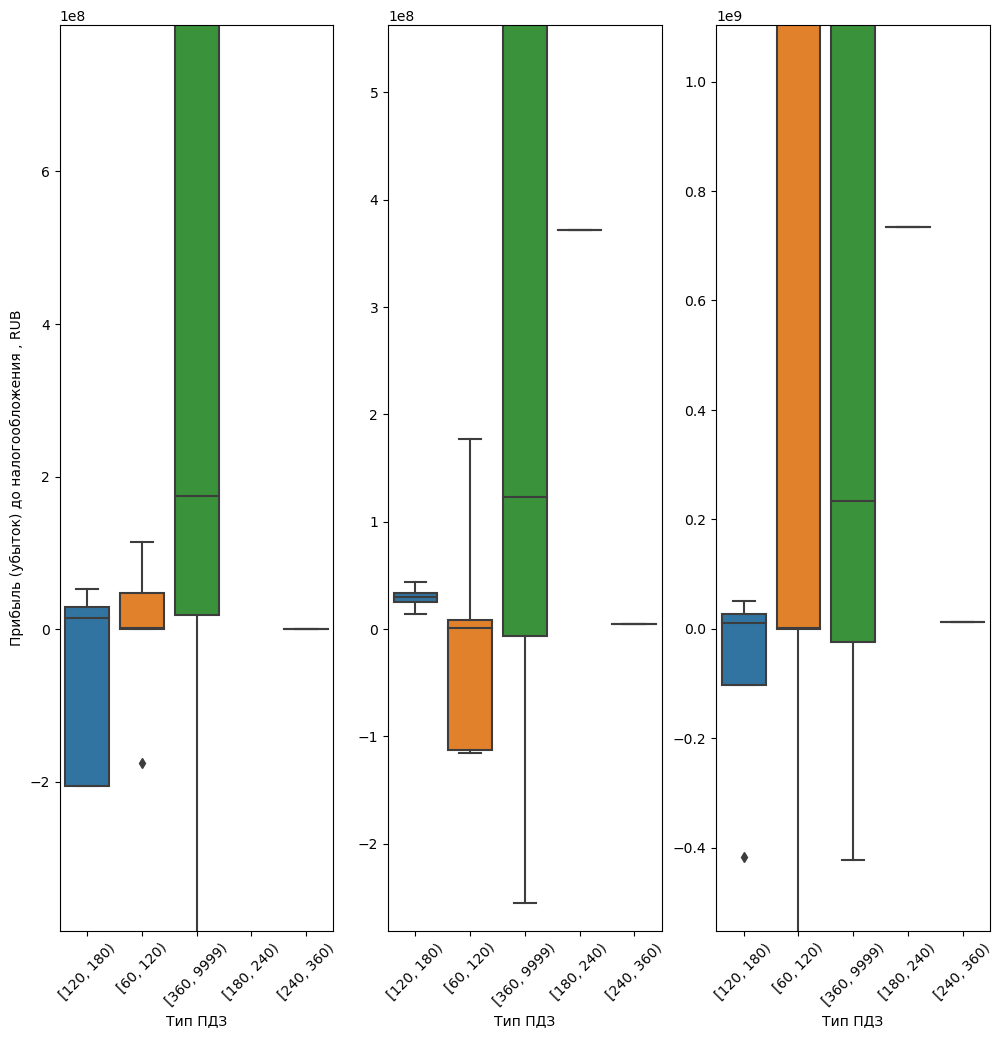

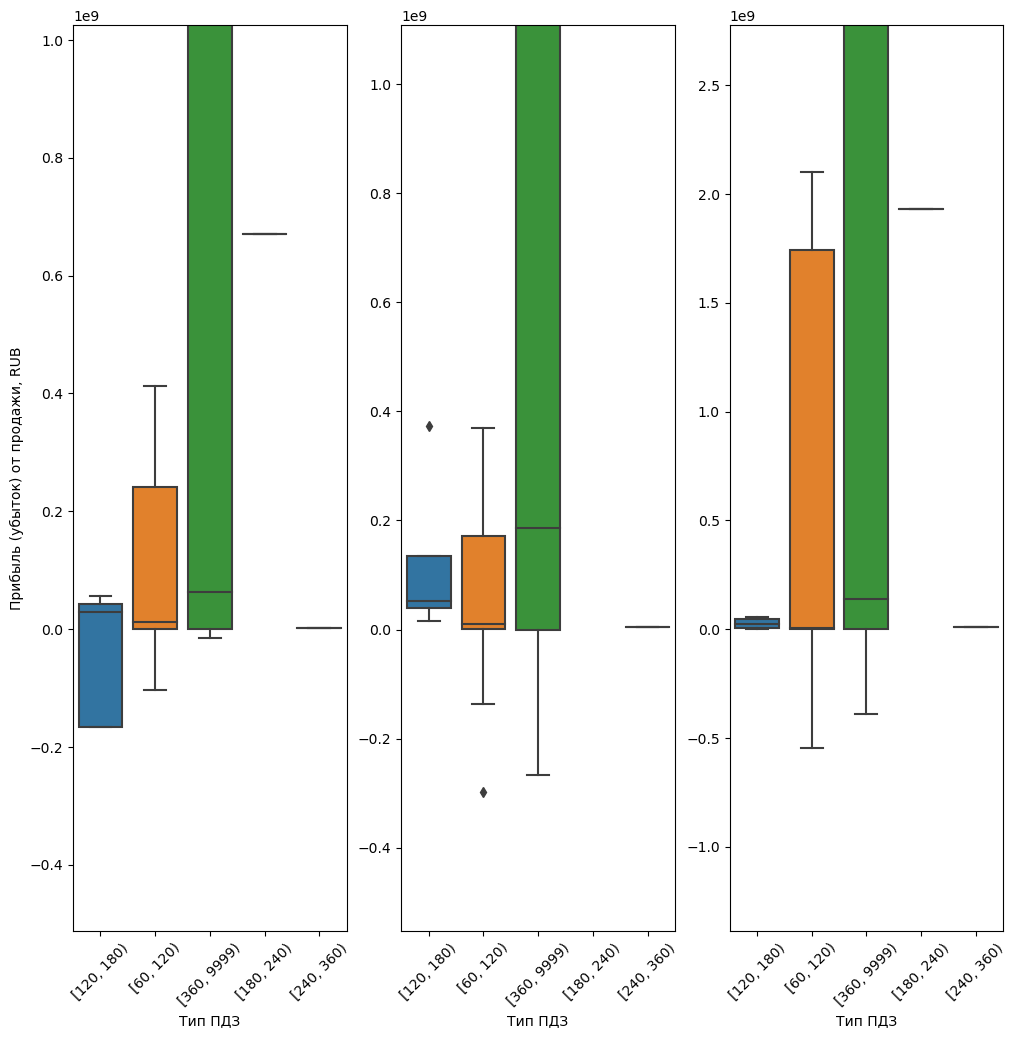

In [47]:
for f in f_list:
    fig = plt.figure(figsize=(12, 12), dpi=100)
    plt.subplot (1, 3, 1)
    f_name='2016'+f    
    ax=sns.boxplot(data=df_2019_outliers, x='Тип ПДЗ', y=df_2019_outliers[f_name]).set(ylabel=f[2:])
    q_25=np.percentile(df_2019_outliers[f_name],25)
    q_75=np.percentile(df_2019_outliers[f_name],75)
    iqr=q_75-q_25
    min_y=q_25-1*iqr
    max_y=q_75+1*iqr
    plt.xticks(rotation=45);
    plt.ylim(min_y,max_y);
    
    plt.subplot (1, 3,2)
    f_name='2017'+f
    bx=sns.boxplot(data=df_2019_outliers, x='Тип ПДЗ', y=df_2019_outliers[f_name]).set(ylabel=None)
    q_25=np.percentile(df_2019_outliers[f_name],25)
    q_75=np.percentile(df_2019_outliers[f_name],75)
    iqr=q_75-q_25
    min_y=q_25-1*iqr
    max_y=q_75+1*iqr    
    plt.xticks(rotation=45);
    plt.ylim(min_y,max_y);   
    
    plt.subplot (1, 3,3)
    f_name='2018'+f
    cx=sns.boxplot(data=df_2019_outliers, x='Тип ПДЗ', y=df_2019_outliers[f_name]).set(ylabel=None)
    q_25=np.percentile(df_2019_outliers[f_name],25)
    q_75=np.percentile(df_2019_outliers[f_name],75)
    iqr=q_75-q_25
    min_y=q_25-1*iqr
    max_y=q_75+1*iqr    
    plt.xticks(rotation=45);
    plt.ylim(min_y,max_y);